In [1]:
### DEFINING EXTRACTION UNIVERSE DATA FROM GENERAL MS EXCEL SOURCE
def get_market_membership_from_excel(path_msci):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables: 
    tab_monthly = 'universe_joined'    
    arr_markets_needed = ['DM', 'FM', 'EM']   
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM'}
    no_slice = slice(None)
    ### Extracting universe data:
    df_universe = pd.read_excel(io = path_msci, sheet_name = tab_monthly, skiprows = [0, 2], header = 0, parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    df_universe = df_universe.loc[no_slice, ['dates', 'region', 'ctry']]
    df_universe.columns = ['Date', 'Market', 'Country']
    df_universe.set_index(['Date', 'Country'], inplace = True)
    ser_universe = df_universe.squeeze()
    ser_universe.sort_index(level = [0, 1], inplace = True)
    ser_universe.replace(dict_markets, inplace = True)
    ser_market_membership = ser_universe[ser_universe.isin(arr_markets_needed)]
    
    return ser_market_membership

In [2]:
### DEFINING EXTRACTION RATING DATA FROM GENERAL MS EXCEL SOURCE
def get_ratings_from_excel(path_xsdm, path_scale, path_msci):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd    
    ### Declaring local constants & variables:  
    arr_currency = ['LC', 'FC'] ### For correct sheet selection in XSDM file
    arr_to_skip = list(range(5)) ### For rows skipping in XSDM file
    arr_to_subtract = ['\(P\)', 'u', ' \*.?$'] ### For ratings clearing 
    str_to_subtract_excess = '|'.join(arr_to_subtract)
    str_to_highlight_mark = '(\*.)'  ### For future reviews markers extracting
    dict_map_to_replace = {'DD': 'D', 'NR': np.NaN, 'RD': 'D', 'SD': 'D', 'WD': np.NaN, 'WR': np.NaN, 'nan': np.NaN} ### For ratings harmonizing
    dict_table = {} ### For sheets accumulation
    ### Collecting sheets:
    with pd.ExcelFile(path_xsdm) as file_excel:
        for str_sheet_name in file_excel.sheet_names:
            arr_sheet_code = str_sheet_name.split(' ')[0].split('_')
            if (len(arr_sheet_code) > 2):
                if (arr_sheet_code[1] in arr_currency):
                    ser_table = pd.read_excel(file_excel, str_sheet_name, squeeze = True, skiprows = arr_to_skip, index_col = 0, parse_dates = True)
                    dict_table[str_sheet_name.split(' ')[0]] = ser_table.stack(dropna = False).sort_index()
    ### Aggregating tables:
    ser_common = pd.concat(dict_table)
    ser_common.index.names = ['Code', 'Date', 'Country']
    ser_common = ser_common.astype(str)
    ### Splitting 'Rating Code' for future analysis:
    df_common = ser_common.to_frame().reset_index().set_index('Code')
    df_common.index = pd.MultiIndex.from_tuples(df_common.index.str.split('_').to_list())
    df_common.index.names = ['Agency', 'Currency', 'Type']
    ### Rating dataFrame polishing:
    df_rating = df_common.set_index(['Date', 'Country'], drop = True, append = True).sort_index()        
    df_rating.columns = ['Rating']
    ### Future reviews markers extracting:
#    df_rating['Initial'] = df_rating['Rating']
    df_rating['Mark'] = df_rating['Rating'].str.extract(pat = str_to_highlight_mark, expand = False).str.slice(-1)    
    ### Suffixes and prefixes handling:    
    df_rating['Rating'] = df_rating['Rating'].str.replace(pat = str_to_subtract_excess, repl = '', regex = True)
    ### Ratings harmonizing with scaling table:
    for map_key, map_value in dict_map_to_replace.items():
        df_rating['Rating'] = df_rating['Rating'].replace(map_key, map_value)
    ### Reading scaling table:
    df_scale = pd.read_excel(path_scale, index_col = 'Rank')
    ### Scaling dataFrame polishing:    
    df_scale.rename_axis('Agency', axis = 1, inplace = True)
    df_scale = df_scale.stack(dropna = False).to_frame().swaplevel().reset_index(1)
    df_scale.rename(columns = {0 : 'Rating'}, inplace = True)
    df_scale.set_index('Rating', append = True, inplace = True)
    ### Adding rank column to result dataframe:
    df_rating = df_rating.join(df_scale, on = ['Agency', 'Rating'], how = 'left')    
#    df_result.drop(['Initial', 'Rating'], axis = 1, inplace = True)
    df_rating.drop(['Rating'], axis = 1, inplace = True)  
    ### Receiving MSCI membership data:    
    ser_market_membership = get_market_membership_from_excel(path_msci)
    ### Adding membership column to result dataframe:    
    df_result = df_rating.join(ser_market_membership, on = ['Date', 'Country'], how = 'left')
    df_result = df_result.set_index('Market', drop = True, append = True)    
    ### Reordering indexes and value columns:
    df_result = df_result[['Rank', 'Mark']]
    df_result = df_result.reorder_levels(['Agency', 'Currency', 'Type', 'Date', 'Market', 'Country'])
    return df_result

In [3]:
### DEFINING EXPONENTIAL WEIGHTS GENERATOR
def get_exp_weights(window_len = 5, halflife_len = 3):
    ### Importing standard modules:    
    import numpy as np
    import pandas as pd
    import math     
    ### Array of regressioon window day numbers descending:
    arr_weight_days = np.arange(window_len, 0, -1) - 1
    ### Creating weights series:
    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    arr_weights = np.exp(math.log(num_period_factor) * arr_weight_days)
    ser_weights = pd.Series(arr_weights)        
    ser_weights.name = 'Weight'
    
    return ser_weights

In [4]:
### ALL RATINGS IMPORTING
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
import matplotlib
### Declaring global constants & variables: 
path_msci = 'Data_Files/Source_Files/sample_universe.xlsx' ### Path for membership source
path_xsdm = 'Data_Files/Source_Files/XSDM.xlsx' ### Path to rating data file
path_scale = 'Data_Files/Source_Files/Ratings_Scale.xlsx' ### Path to rating comparision file 
All = slice(None)
### Receiving aggregated ratings table:
df_rating_full = get_ratings_from_excel(path_xsdm, path_scale, path_msci)
### Dropping non-universe countries:
### Comment the next line to get full ranking history (without dropping observations not covered by ISON Universe)
#df_rating_full = df_rating_full.loc[(All, All, All, All, ['DM', 'FM', 'EM'], All), :]

In [5]:
### COMPARING MDY'S RATING TYPES (ISSUER vs DEBT)
### Creating table for comparision:
df_mdy = df_rating_full.loc['MDY']['Rank'].unstack(level = 'Type')
df_mdy.sort_index(level = ['Currency', 'Date', 'Country'], inplace = True)
### Table with both type's ratings available:
ser_mdy_both = df_mdy.dropna()['DEBT'] - df_mdy.dropna()['ISSUER']
### Table with different rating values:
ser_mdy_differ = ser_mdy_both[ser_mdy_both != 0]
ser_mdy_differ.name = 'Delta'
#print(df_mdy.tail())
### Comparision process:
print('MDY Ratings common stats: Number of all observations:', len(df_mdy.index))
print('MDY Ratings common stats: Number of observations with at least one type\'s rating available:', 
      '{:.2%}'.format(len(df_mdy.dropna(how = 'all').index) / len(df_mdy.index)), '(', len(df_mdy.dropna(how = 'all').index), ')')
print('MDY Ratings common stats: Number of observations with both types ratings available:', 
      '{:.2%}'.format(len(df_mdy.dropna().index) / len(df_mdy.index)), '(', len(df_mdy.dropna().index), ')')
print('MDY Ratings common stats: Number of observations with only DEBT rating available:', 
      '{:.2%}'.format(len(df_mdy.loc[df_mdy['DEBT'].notna() & df_mdy['ISSUER'].isna()].index) / len(df_mdy.index)), 
      '(', len(df_mdy.loc[df_mdy['DEBT'].notna() & df_mdy['ISSUER'].isna()].index), ')')
print('MDY Ratings common stats: Observations with only DEBT rating available distribution:','\n',
      df_mdy['DEBT'].loc[df_mdy['DEBT'].notna() & df_mdy['ISSUER'].isna()].groupby(['Currency', 'Market']).count())
print('MDY Ratings common stats: Number of observations with only ISSUER rating available:', 
      '{:.2%}'.format(len(df_mdy.loc[df_mdy['DEBT'].isna() & df_mdy['ISSUER'].notna()].index) / len(df_mdy.index)), 
      '(', len(df_mdy.loc[df_mdy['DEBT'].isna() & df_mdy['ISSUER'].notna()].index), ')')
print('MDY Ratings common stats: Observations with only ISSUER rating available distribution:','\n',
      df_mdy['ISSUER'].loc[df_mdy['DEBT'].isna() & df_mdy['ISSUER'].notna()].groupby(['Currency', 'Market']).count())
print('MDY Ratings both ratings available stats', '(', len(ser_mdy_both.index), ')', ': Number of observations with equal ratings values:', 
      '{:.2%}'.format(len(ser_mdy_both[ser_mdy_both == 0].index) / len(ser_mdy_both.index)), 
      '(', len(ser_mdy_both[ser_mdy_both == 0].index), ')')
print('MDY Ratings both ratings available stats', '(', len(ser_mdy_both.index), ')', ': Number of observations with different ratings values:', 
      '{:.2%}'.format(len(ser_mdy_both[ser_mdy_both != 0].index) / len(ser_mdy_both.index)), 
      '(', len(ser_mdy_both[ser_mdy_both != 0].index), ')')
print('MDY Ratings different rating values', '(', len(ser_mdy_differ.index), ')', ': Currencies & Markets distribution:', '\n',
      ser_mdy_differ.abs().groupby(['Currency', 'Market']).agg(['count', 'min', 'max', 'mean']))

MDY Ratings common stats: Number of all observations: 79968
MDY Ratings common stats: Number of observations with at least one type's rating available: 54.81% ( 43832 )
MDY Ratings common stats: Number of observations with both types ratings available: 34.48% ( 27575 )
MDY Ratings common stats: Number of observations with only DEBT rating available: 8.63% ( 6903 )
MDY Ratings common stats: Observations with only DEBT rating available distribution: 
 Currency  Market
FC        DM        805
          EM        503
LC        DM        945
          EM        624
Name: DEBT, dtype: int64
MDY Ratings common stats: Number of observations with only ISSUER rating available: 11.70% ( 9354 )
MDY Ratings common stats: Observations with only ISSUER rating available distribution: 
 Currency  Market
FC        DM        1119
          EM         783
          FM        1878
LC        DM         115
          EM         509
          FM        2447
Name: ISSUER, dtype: int64
MDY Ratings both ratings 

In [6]:
# TYPE'S CHOOSING AND JOINING
### Moving Types to columns and flattening columns to one level:
df_rating_type = df_rating_full.unstack('Type')
df_rating_type.sort_index(level = ['Agency', 'Currency', 'Date', 'Country'], inplace = True)
df_rating_type.columns = ['_'.join(iter_tup_col).rstrip('_') for iter_tup_col in df_rating_type.columns.values]
### Adding final columns:
df_rating_type['Rank'] = np.NaN
df_rating_type['Mark'] = np.NaN
### Filling final columns:
df_rating_type.loc[('FITCH', All), 'Rank'] = df_rating_type['Rank_DEBT']
df_rating_type.loc[('FITCH', All), 'Mark'] = df_rating_type['Mark_DEBT']
df_rating_type.loc[('SP', All), 'Rank'] = df_rating_type['Rank_ISSUER']
df_rating_type.loc[('SP', All), 'Mark'] = df_rating_type['Mark_ISSUER']
df_rating_type.loc[('MDY', All), 'Rank'] = df_rating_type['Rank_ISSUER']
df_rating_type.loc[('MDY', All), 'Mark'] = df_rating_type['Mark_ISSUER']
df_rating_type.loc[(df_rating_type.index.get_level_values(0) == 'MDY') & df_rating_type['Rank'].isna(), 'Mark'] = df_rating_type['Mark_DEBT']
df_rating_type.loc[('MDY', All), 'Rank'] = df_rating_type.loc[('MDY', All), 'Rank'].combine_first(df_rating_type.loc[('MDY', All), 'Rank_DEBT'])
### Removing source data columns:
df_rating_type = df_rating_type[['Rank', 'Mark']]
#df_rating_type.to_excel('Data_Files/Test_Files/Types_Merging.xlsx', merge_cells = False)

In [ ]:
### COMPARING RATING CURRENCIES (FC vs LC)
### Creating table for comparision:
df_cur = df_rating_type['Rank'].unstack('Currency')
df_cur.sort_index(level = ['Agency', 'Date', 'Country'], inplace = True)
#df_cur.to_excel('Data_Files/Test_Files/Currencies_Merging.xlsx', merge_cells = False)
### Table with both type's ratings available:
ser_cur_both = df_cur.dropna()['FC'] - df_cur.dropna()['LC']
### Table with different rating values:
ser_cur_differ = ser_cur_both[ser_cur_both != 0]
ser_cur_differ.name = 'Delta'
### LC only rating table:
ser_cur_LC = df_cur['LC'].loc[df_cur['FC'].isna() & df_cur['LC'].notna()]
### LC only countries:
arr_cur_keys = ser_cur_LC.groupby(['Agency', 'Market', 'Country']).groups.keys()
### Comparision process:
print('Ratings common stats: Number of all observations:', len(df_cur.index))
print('Ratings common stats: Number of observations with at least one currencie\'s rating available:', 
      '{:.2%}'.format(len(df_cur.dropna(how = 'all').index) / len(df_cur.index)), '(', len(df_cur.dropna(how = 'all').index), ')')
print('Ratings common stats: Number of observations with both ratings available:', 
      '{:.2%}'.format(len(df_cur.dropna().index) / len(df_cur.index)), '(', len(df_cur.dropna().index), ')')
print('Ratings common stats: Number of observations with only FC rating available:', 
      '{:.2%}'.format(len(df_cur.loc[df_cur['FC'].notna() & df_cur['LC'].isna()].index) / len(df_cur.index)), 
      '(', len(df_cur.loc[df_cur['FC'].notna() & df_cur['LC'].isna()].index), ')')
print('Ratings common stats: Observations with only FC rating available distribution:','\n',
      df_cur['FC'].loc[df_cur['FC'].notna() & df_cur['LC'].isna()].groupby(['Market', 'Agency']).count())
print('Ratings common stats: Number of observations with only LC rating available:', 
      '{:.2%}'.format(len(df_cur.loc[df_cur['FC'].isna() & df_cur['LC'].notna()].index) / len(df_cur.index)), 
      '(', len(df_cur.loc[df_cur['FC'].isna() & df_cur['LC'].notna()].index), ')')
print('Ratings common stats: Observations with only LC rating available distribution:','\n',
      df_cur['LC'].loc[df_cur['FC'].isna() & df_cur['LC'].notna()].groupby(['Market', 'Agency']).count())
print('Both ratings available stats', '(', len(ser_cur_both.index), ')', ': Number of observations with equal ratings values:', 
      '{:.2%}'.format(len(ser_cur_both[ser_cur_both == 0].index) / len(ser_cur_both.index)), 
      '(', len(ser_cur_both[ser_cur_both == 0].index), ')')
print('Both ratings available stats', '(', len(ser_cur_both.index), ')', ': Number of observations with different ratings values:', 
      '{:.2%}'.format(len(ser_cur_both[ser_cur_both != 0].index) / len(ser_cur_both.index)), 
      '(', len(ser_cur_both[ser_cur_both != 0].index), ')')
print('Different ratings values', '(', len(ser_cur_differ.index), ')', ': Markets distribution:', '\n',
      ser_cur_differ.abs().groupby(['Market', 'Agency']).agg(['count', 'min', 'max', 'mean']))
print('LC only ratings stats: Countries distribution:','\n', ser_cur_LC.groupby(['Agency', 'Market', 'Country']).agg(['count', 'min', 'max', 'mean']))
for iter_tup in arr_cur_keys:
#    df_cur.loc[(iter_tup[0], All, iter_tup[1], iter_tup[2])].plot(figsize = (5, 2), title = str(iter_tup[0]) + ' / ' + str(iter_tup[1]) + ' / ' + str(iter_tup[2]),
#                                                                  use_index = False, xticks = [])
    iter_df_lc = df_cur.dropna().loc[(iter_tup[0], All, iter_tup[1], iter_tup[2])]
    if (len(iter_df_lc.index) > 0):
        print('LC only ratings stats: Number of observations for', iter_tup, 'with different ratings:',
              '{:.2%}'.format(len(iter_df_lc.loc[iter_df_lc['FC'] == iter_df_lc['LC']].index) / len(iter_df_lc.index)))
        print('LC only ratings stats: Ratio FC to LC ratings for', iter_tup, ':',
              '{:.2%}'.format(iter_df_lc['FC'].mean() / iter_df_lc['LC'].mean()))
    else:
        print('LC only ratings stats: No observations to compare currency ratings for:', iter_tup)

In [8]:
### CURRENCY'S CHOOSING AND JOINING
df_rating_cur = df_rating_type.unstack('Currency')
df_rating_cur.sort_index(level = ['Agency', 'Date', 'Country'], inplace = True)
df_rating_cur.columns = ['_'.join(iter_tup_col).rstrip('_') for iter_tup_col in df_rating_cur.columns.values]
### Adding final columns:
df_rating_cur['Rank'] = df_rating_cur['Rank_FC']
df_rating_cur['Mark'] = df_rating_cur['Mark_FC']
### Additional filling final columns with LC values in case if all FC values are empty:
arr_lc_keys = df_rating_cur.loc[df_rating_cur['Rank_FC'].isna() & df_rating_cur['Rank_LC'].notna()].groupby(['Agency', 'Country']).groups.keys()
for iter_tup in arr_lc_keys:
    if (len(df_rating_cur['Rank_FC'].dropna().loc[(iter_tup[0], All, All, iter_tup[1])].index) == 0):
        print(iter_tup)
        iter_tup_index = (iter_tup[0], All, All, iter_tup[1])
        df_rating_cur.loc[iter_tup_index, 'Mark'] = df_rating_cur.loc[iter_tup_index, 'Mark_LC']          
        df_rating_cur.loc[iter_tup_index, 'Rank'] = df_rating_cur.loc[iter_tup_index, 'Rank_LC']
df_rating_cur = df_rating_cur[['Rank', 'Mark']]        
#df_rating_cur.to_excel('Data_Files/Test_Files/Currencies_Merging.xlsx', merge_cells = False)        

('FITCH', 'TW')
('FITCH', 'UG')


In [ ]:
### ADDITIONAL REVISION MARKERS RESEARCH
### Function for const mark length counting:
def mark_length(ser_group_agency):
    ser_mark_length = pd.Series(0, index = ser_group_agency.index)
    ser_mark_length = ser_group_agency.groupby(((ser_group_agency != ser_group_agency.shift(1)) & (ser_group_agency.isna())).cumsum()).cumcount()
    ser_mark_length.loc[ser_group_agency.isna() | ser_group_agency.shift(-1).notna()] = 0
    return ser_mark_length
### Common providers table:
df_mark_plus = df_rating_cur.unstack('Agency').swaplevel(axis = 1).sort_index(ascending = [True, False], axis = 1).sort_index(level = ['Country', 'Date'])
#print(df_mark_plus)
for iter_agency in df_mark_plus.columns.get_level_values(0).unique():
#    print(iter_agency)
    ### Selecting provider data:
    df_iter_plus = df_mark_plus[iter_agency]
    ### Calculating revision mark length:
    df_iter_plus = df_iter_plus.assign(Mark_Length = df_iter_plus['Mark'].groupby('Country').apply(lambda iter_group: mark_length(iter_group)))
    df_iter_plus.replace(to_replace = 0, value = np.NaN, inplace = True)
    ### Calculating revisions after mark revision period end:
    df_iter_plus = df_iter_plus.assign(Mark_Delta = df_iter_plus['Rank'].groupby('Country').diff().shift(-1))
    df_iter_plus.loc[df_iter_plus['Mark_Length'].isna(), 'Mark_Delta'] = np.NaN    
    df_iter_plus.loc[df_iter_plus['Mark_Delta'].isna(), 'Mark_Length'] = np.NaN     
    ### Marked ranks proportion printing:
    print(iter_agency, ': Any marks proportion in total not-NaN ranks number:', 
          '{:.2%}'.format(df_iter_plus['Mark'].count() / df_iter_plus['Rank'].count()),
          '(', df_iter_plus['Mark'].count(), 'observations )')
    print(iter_agency, ': Positive marks proportion in total not-NaN ranks number:', 
          '{:.2%}'.format(len(df_iter_plus.loc[df_iter_plus['Mark'] == '+'].index) / df_iter_plus['Rank'].count()),
          '(', len(df_iter_plus.loc[df_iter_plus['Mark'] == '+'].index), 'observations )')    
    print(iter_agency, ': Negative marks proportion in total not-NaN ranks number:', 
          '{:.2%}'.format(len(df_iter_plus.loc[df_iter_plus['Mark'] == '-'].index) / df_iter_plus['Rank'].count()),
          '(', len(df_iter_plus.loc[df_iter_plus['Mark'] == '-'].index), 'observations )')     
    ### Marked ranks unbroken periods length printing:    
    print(iter_agency, ': Average unbroken marked period length for any mark:', round(df_iter_plus['Mark_Length'].mean(), 2))
    print(iter_agency, ': Average unbroken marked period length for positive mark:', 
          round(df_iter_plus.loc[df_iter_plus['Mark'] == '+', 'Mark_Length'].mean(), 2))    
    print(iter_agency, ': Average unbroken marked period length for negative mark:', 
          round(df_iter_plus.loc[df_iter_plus['Mark'] == '-', 'Mark_Length'].mean(), 2)) 
    ### Marked ranks unbroken periods results printing:     
    print(iter_agency, ': Marked periods number:', df_iter_plus['Mark_Delta'].count())   
    print(iter_agency, ': Marked periods, that ends with revisions, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[df_iter_plus['Mark_Delta'].abs() > 0].index) / df_iter_plus['Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[df_iter_plus['Mark_Delta'].abs() > 0].index), 'observations )') 
    print(iter_agency, ': Marked periods, that with no revision, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[df_iter_plus['Mark_Delta'] == 0].index) / df_iter_plus['Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[df_iter_plus['Mark_Delta'] == 0].index), 'observations )')   
    ### Positively marked ranks unbroken periods results printing:     
    print(iter_agency, ': Positively marked periods number:', df_iter_plus.loc[df_iter_plus['Mark'] == '+', 'Mark_Delta'].count())   
    print(iter_agency, ': Positively marked periods, that ends with revisions, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'].abs() > 0)].index) \
                          / df_iter_plus.loc[df_iter_plus['Mark'] == '+', 'Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'].abs() > 0)].index), 'observations )') 
    print(iter_agency, ': Positively marked periods, that ends with positive revisions, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'] > 0)].index) \
                          / df_iter_plus.loc[df_iter_plus['Mark'] == '+', 'Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'] > 0)].index), 'observations )') 
    print(iter_agency, ': Positively marked periods, that ends with negative revisions, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'] < 0)].index) \
                          / df_iter_plus.loc[df_iter_plus['Mark'] == '+', 'Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'] < 0)].index), 'observations )')     
    print(iter_agency, ': Positively marked periods, that ends with no revision, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'] == 0)].index) \
                          / df_iter_plus.loc[df_iter_plus['Mark'] == '+', 'Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'] == 0)].index), 'observations )') 
    print(iter_agency, ': Positively marked periods ends mean positive revisions delta:',
          round(df_iter_plus.loc[(df_iter_plus['Mark'] == '+') & (df_iter_plus['Mark_Delta'] > 0), 'Mark_Delta'].mean(), 2))
    ### Negatively marked ranks unbroken periods results printing:      
    print(iter_agency, ': Negatively marked periods number:', df_iter_plus.loc[df_iter_plus['Mark'] == '-', 'Mark_Delta'].count())   
    print(iter_agency, ': Negatively marked periods, that ends with revisions, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'].abs() > 0)].index) \
                          / df_iter_plus.loc[df_iter_plus['Mark'] == '-', 'Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'].abs() > 0)].index), 'observations )') 
    print(iter_agency, ': Negatively marked periods, that ends with positive revisions, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'] > 0)].index) \
                          / df_iter_plus.loc[df_iter_plus['Mark'] == '-', 'Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'] > 0)].index), 'observations )') 
    print(iter_agency, ': Negatively marked periods, that ends with negative revisions, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'] < 0)].index) \
                          / df_iter_plus.loc[df_iter_plus['Mark'] == '-', 'Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'] < 0)].index), 'observations )')     
    print(iter_agency, ': Negatively marked periods, that with no revision, proportion:',
          '{:.2%}'.format(len(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'] == 0)].index) \
                          / df_iter_plus.loc[df_iter_plus['Mark'] == '-', 'Mark_Delta'].count()),
          '(', len(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'] == 0)].index), 'observations )') 
    print(iter_agency, ': Negatively marked periods ends mean negative revisions delta:',
          round(df_iter_plus.loc[(df_iter_plus['Mark'] == '-') & (df_iter_plus['Mark_Delta'] < 0), 'Mark_Delta'].mean(), 2))    

In [33]:
### CORRECTING POSITIVELY MARKED RANKS:
df_rating_cur.loc[df_rating_cur['Mark'] == '+', 'Rank'] = df_rating_cur['Rank'] + 1
df_rating_cur.loc[df_rating_cur['Mark'] == '-', 'Rank'] = df_rating_cur['Rank'] - 1
#df_rating_cur.to_excel('Data_Files/Test_Files/Test_Marking_Plus.xlsx', merge_cells = False)  

In [ ]:
### RATINGS ANALYZING:
### Creating table for comparision:
df_agency = df_rating_cur['Rank'].unstack('Agency')
df_agency.sort_index(level = ['Date', 'Country'], inplace = True)
#df_agency.to_excel('Data_Files/Test_Files/Agencies_Unstacked.xlsx', merge_cells = False)
### Creating auxiliar tables:
dict_col = {}
for iter_num, iter_col in enumerate(df_agency.columns):
    dict_col[iter_col] = df_agency.columns.to_list()[ : iter_num] + df_agency.columns.to_list()[(iter_num + 1) : ]
df_solo = df_agency[df_agency.isna().sum(axis = 1) == 2]
df_duo = df_agency[df_agency.isna().sum(axis = 1) == 1]
df_trio = df_agency.dropna()
ser_difference = df_agency.dropna(thresh = 2).max(axis = 1) - df_agency.dropna(thresh = 2).min(axis = 1)
ser_trio_difference = df_agency.dropna().max(axis = 1) - df_agency.dropna().min(axis = 1)
### Comparision process:
print('Ratings common stats: Number of all observations:', len(df_agency.index))
print('Ratings common stats: Number of observations without any rating:', 
      '{:.2%}'.format(len(df_agency[df_agency.isna().all(axis = 1)].index) / len(df_agency.index)), '(', len(df_agency[df_agency.isna().all(axis = 1)].index), ')')
print('No ratings stats', '(', len(df_agency[df_agency.isna().all(axis = 1)].index), ')', ': Countries distribution:', '\n',
      df_agency[df_agency.isna().all(axis = 1)].reset_index('Date').groupby(['Market', 'Country'])['Date'].agg(['first', 'last', 'size']))
print('Ratings common stats: Number of observations with at least one rating available:', 
      '{:.2%}'.format(len(df_agency.dropna(how = 'all').index) / len(df_agency.index)), '(', len(df_agency.dropna(how = 'all').index), ')')
print('Ratings common stats: Number of observations with exactly one rating available:', 
      '{:.2%}'.format(len(df_solo.index) / len(df_agency.index)), '(', len(df_solo.index), ')')
print('One rating stats', '(', len(df_solo.index), ')', ': Countries distribution:', '\n',
      df_solo.reset_index('Date').groupby(['Market', 'Country'])['Date'].agg(['first', 'last', 'size']))
print('One rating stats', '(', len(df_solo.index), ')', ': Agencies distribution:')
for iter_col in df_solo.columns:
    print(iter_col, ':',  '{:.2%}'.format(df_solo[iter_col].count() / len(df_solo.index)), '(', df_solo[iter_col].count(), ')')
print('One rating stats', '(', len(df_solo.index), ')', ': Markets distribution:', '\n', df_solo.groupby('Market').count()) 
print('Ratings common stats: Mean maximum pairwise difference for observations, where not all ranks are equal:', round(ser_difference[ser_difference != 0].mean(), 2))  
print('Ratings common stats: Number of observations with exactly two ratings available:', 
      '{:.2%}'.format(len(df_duo.index) / len(df_agency.index)), '(', len(df_duo.index), ')')
print('Two ratings stats', '(', len(df_duo.index), ')', ': Agencies distribution:')
for iter_col in df_duo.columns:
    iter_count = len(df_duo[dict_col[iter_col]].dropna().index)
    iter_ser_diff = df_duo[dict_col[iter_col]].dropna().iloc[All, 0] - df_duo[dict_col[iter_col]].dropna().iloc[All, 1]
    iter_ser_diff = iter_ser_diff[iter_ser_diff != 0].abs()
#iter_ser_diff.mean()    
    print(dict_col[iter_col], 'not NaN pairs:',
          '{:.2%}'.format(iter_count / len(df_duo.index)), '(', iter_count, ') , equal observations part:', 
          '{:.2%}'.format(df_duo[dict_col[iter_col]].dropna().iloc[:, 0].ne(df_duo[dict_col[iter_col]].dropna().iloc[:, 1], axis = 0).sum() / iter_count),
          '(', df_duo[dict_col[iter_col]].dropna().iloc[:, 0].ne(df_duo[dict_col[iter_col]].dropna().iloc[:, 1], axis = 0).sum(), ')')       
    print(dict_col[iter_col], 'not NaN pairs:',
          '{:.2%}'.format(iter_count / len(df_duo.index)), '(', iter_count, ') , not equal observations mean difference:', round(iter_ser_diff.mean(), 2))      
print('Ratings common stats: Number of observations with all ratings available:', 
      '{:.2%}'.format(len(df_trio.index) / len(df_agency.index)), '(', len(df_trio.index), ')')
print('Three ratings stats: All ratings equal:', '{:.2%}'.format(df_trio.eq(df_trio.iloc[:, 0], axis = 0).all(axis = 1).sum() / len(df_trio.index)),
      '(', df_trio.eq(df_trio.iloc[:, 0], axis = 0).all(axis = 1).sum(), ')')
print('Three ratings stats', '(', len(df_trio.index), ')', ': Two of three ratings equality distribution:')
num_pair_sum = 0
for iter_col in df_trio.columns:
    iter_pair_sum = df_trio[dict_col[iter_col][0]].eq(df_trio[dict_col[iter_col][1]]).sum() - df_trio.eq(df_trio.iloc[:, 0], axis = 0).all(axis = 1).sum()
    num_pair_sum = num_pair_sum + iter_pair_sum
    print('Equal just pair', dict_col[iter_col], ':', '{:.2%}'.format(iter_pair_sum / len(df_trio.index)), '(', iter_pair_sum, ')')   
print('Three ratings stats: Total equal pairs number:', '{:.2%}'.format(num_pair_sum / len(df_trio.index)), '(', num_pair_sum, ')')   
print('Three ratings stats: All different values:',
      '{:.2%}'.format(1 - (num_pair_sum + df_trio.eq(df_trio.iloc[:, 0], axis = 0).all(axis = 1).sum()) / len(df_trio.index)),
      '(', len(df_trio.index) - (df_trio.eq(df_trio.iloc[:, 0], axis = 0).all(axis = 1).sum() + num_pair_sum), ')')   
print('Three ratings stats: Mean maximum pairwise difference for observations, where not all ranks are equal:', 
      round(ser_trio_difference[ser_trio_difference != 0].mean(), 2))  
df_agency.reset_index(level = 'Market', drop = True, inplace = True)
### Additional cross-sectional stats generating and saving:
#df_agency['Delta'] = (df_agency.max(axis = 1) - df_agency.min(axis = 1)).abs()
#df_agency.unstack('Country').reorder_levels([1, 0], axis = 1).sort_index(level = [0, 1], axis = 1).to_excel('Data_Files/Test_Files/Countries.xlsx', merge_cells = False)
#df_agency.sort_values('Delta', ascending = False).index.get_level_values(1).unique()
### Additional timline stats generating and saving:
#df_delta = df_agency.sort_index(level = ['Country', 'Date']).copy()
#arr_delta = []
#for iter_col in df_delta.columns:
#    df_delta[iter_col + '_delta'] =  np.NaN
#for iter_country in df_delta.index.get_level_values(1).unique():
#    iter_df = df_delta.loc[(All, iter_country), :].sort_index()
#    for iter_col in df_agency.columns:
#        iter_df[iter_col + '_delta'] = (iter_df[iter_col] - iter_df[iter_col].shift()).abs()
#    arr_delta.append(iter_df)
#df_delta = pd.concat(arr_delta).sort_index(level = ['Country', 'Date'])
#df_delta.unstack('Country').reorder_levels([1, 0], axis = 1).sort_index(level = [0, 1], 
#                                                                        axis = 1)[['AR', 'GR', 'ID', 'IE', 'PE', 'PT']].to_excel('Data_Files/Test_Files/Agencies.xlsx', 
#                                                                                                                                 merge_cells = False)  

In [34]:
### COLLAPSING VARIANTS COMPARING
### Function for const length counting:
def const_length(ser_group_agency):
    ser_group_weight = pd.Series(1, index = ser_group_agency.index)
    ser_group_weight = ser_group_agency.groupby((ser_group_agency != ser_group_agency.shift(1)).cumsum()).cumcount() + 1
    return ser_group_weight
### Table for rankings keeping:
df_rating_agency = df_rating_cur['Rank'].unstack('Agency').sort_index(level = ['Country', 'Date'])
### Array of agencies names:
arr_agency = df_rating_agency.columns
### Table for collapsing variants collecting:
df_rating_res = pd.DataFrame(index = df_rating_agency.index)
df_rating_res['Median'] = round(df_rating_agency.median(axis = 1), 2)
df_rating_res['Mean'] = round(df_rating_agency.mean(axis = 1), 2)
### Table of freshness weight types:
#arr_weight_kind = ['month minus', 'month over', 'year over', 'month trigger', 'year trigger', 'month half life']
arr_weight_kind = ['month half life']
### Weights for half-life:
num_window = 310
num_halflife = 3
ser_weights_halflife = get_exp_weights(window_len = num_window, halflife_len = num_halflife)[::-1].reset_index(drop = True)
### Freshness weights calculation:
for iter_kind in arr_weight_kind:
    df_rating_agency = df_rating_cur['Rank'].unstack('Agency').sort_index(level = ['Country', 'Date'], ascending = [True, True])
    ### Initialising weights vector
    df_rating_weight = pd.DataFrame(index = df_rating_agency.index)
    ### Unchanged datepoints quantity calculating:
    for iter_agency in arr_agency:
        df_rating_weight[iter_agency] = 1
        df_rating_weight[iter_agency] = df_rating_agency[iter_agency].groupby(['Country']).apply(lambda iter_group: const_length(iter_group))        
    ### Freshness weights calculation:
    if (iter_kind == 'month minus'):
        ### Weight as unchanged datepoints quantity with changed sign:      
        df_rating_weight = -df_rating_weight.sub(df_rating_weight.sum(axis = 1), axis = 0)
    if (iter_kind == 'month over'):        
        ### Weight as inversed unchanged datepoints quantity:
        df_rating_weight = 1 / df_rating_weight
    if (iter_kind == 'year over'):
        ### Weight as inversed unchanged datepoints years quantity:
        df_rating_weight = ((df_rating_weight - 1) // 12) + 1  
        df_rating_weight = 1 / df_rating_weight         
    if (iter_kind == 'month trigger'):
        ### Weight as inversed unchanged datepoints quantity revised only on any change:
        df_rating_weight = df_rating_weight.sub(df_rating_weight.min(axis = 1) - 1, axis = 0)
        df_rating_weight = 1 / df_rating_weight  
    if (iter_kind == 'year trigger'):
        ### Weight as inversed unchanged datepoints years quantity revised only on any change:
        df_rating_weight = df_rating_weight.sub(df_rating_weight.min(axis = 1) - 1, axis = 0)        
        df_rating_weight = ((df_rating_weight - 1) // 12) + 1              
        df_rating_weight = 1 / df_rating_weight 
    if (iter_kind == 'month half life'):
        ### Weight as exponentially weighted unchanged datepoints quantity revised only on any change:
        for iter_agency in df_rating_agency.columns:
            df_rating_weight[iter_agency] = pd.Series(ser_weights_halflife[df_rating_weight[iter_agency]].values, index = df_rating_weight[iter_agency].index)
    ### Zeroing of weights of NaN rank values:
    df_rating_weight[df_rating_agency.isna()] = 0    
    ### Zeroing NaN rank values:
#    df_rating_agency.fillna(0, inplace = True)
    ### Freshness means calculation:
    df_rating_weight  = df_rating_weight.div(df_rating_weight.sum(axis = 1), axis = 0)  
    df_rating_res['Fresh ' + iter_kind] = round(df_rating_agency.mul(df_rating_weight, axis = 0).sum(axis = 1), 2)
    
### Freshness means completion
df_rating_res[df_rating_agency.isna().sum(axis = 1) == 3] = np.NaN
df_rating_res[(round(df_rating_res, 0) == 0) & (df_rating_res <= 0)] = -0.5 - 1 / 10000000
df_rating_res[(round(df_rating_res, 0) == 0) & (df_rating_res > 0)] = 0.5 + 1 / 10000000
### Aggregated table:
#df_rating_collapsed_plus = pd.concat([df_rating_agency, df_rating_weight, df_rating_weight_natural, df_rating_res], axis = 1, 
#                                sort = True).sort_index(level = ['Country', 'Date'])
df_rating_collapsed = pd.concat([df_rating_agency, df_rating_res], axis = 1, sort = True).sort_index(level = ['Country', 'Date'], ascending = [True, True])
#round(df_rating_collapsed, 0).to_excel('Data_Files/Test_Files/Test_Collapsing_Full.xlsx', merge_cells = False)      
#round(df_rating_collapsed, 0).to_excel('Data_Files/Test_Files/Collapsing_Full_Marked_03.xlsx', merge_cells = False)
#df_rating_collapsed_plus.to_excel('Data_Files/Test_Files/Test_Weighting.xlsx', merge_cells = False)

In [88]:
### DAILY RESAMPLING FOR REVISION MONTHS
df_rating_agg = df_rating_collapsed.copy()
df_rating_agg.drop(['Mean'], axis = 1, inplace = True)
df_rating_agg.columns = ['FITCH', 'MDY', 'SP', 'Median', 'COLLAPSED']
df_rating_agg = df_rating_agg[['FITCH', 'MDY', 'SP']]
dict_ser_deltas = {}
### Main loop:
for iter_agency in df_rating_agg.columns: ### Agencies iterating
    ### Grades series defining:
    iter_ser_grades = df_rating_agg[iter_agency].dropna().sort_index(level = ['Country', 'Date'], ascending = [True, True])
    ### Deltas series calculation:
    iter_ser_deltas = df_rating_agg[iter_agency].dropna().groupby('Country').diff().sort_index(level = ['Country', 'Date'], ascending = [True, True]).abs().dropna()
    iter_ser_deltas = iter_ser_deltas.loc[iter_ser_deltas > 0]
    iter_ser_deltas = iter_ser_deltas / iter_ser_deltas
    iter_ser_deltas = iter_ser_deltas.reset_index()
    iter_ser_deltas['Month'] = iter_ser_deltas['Date'].dt.to_period('M')
    iter_ser_deltas = iter_ser_deltas.set_index(['Country', 'Month'], drop = True).drop('Date', axis = 1)
    iter_ser_deltas = iter_ser_deltas.groupby(['Country', 'Month']).apply(lambda iter_group: iter_group.droplevel(0).resample('D').ffill())
    iter_ser_deltas.reset_index(1, drop = True, inplace = True)
    iter_ser_deltas = iter_ser_deltas.drop('Market', axis = 1).squeeze()
    iter_ser_deltas.to_excel('Data_Files/Test_Files/Revisions_Daily_' + iter_agency + '.xlsx', merge_cells = False)
#    with pd.ExcelWriter('Data_Files/Test_Files/Revisions_Daily.xlsx') as writer:
#        iter_ser_deltas.to_excel(writer, sheet_name = iter_agency, merge_cells = False)

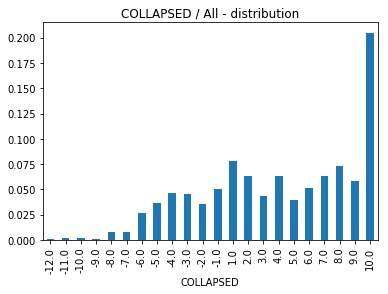

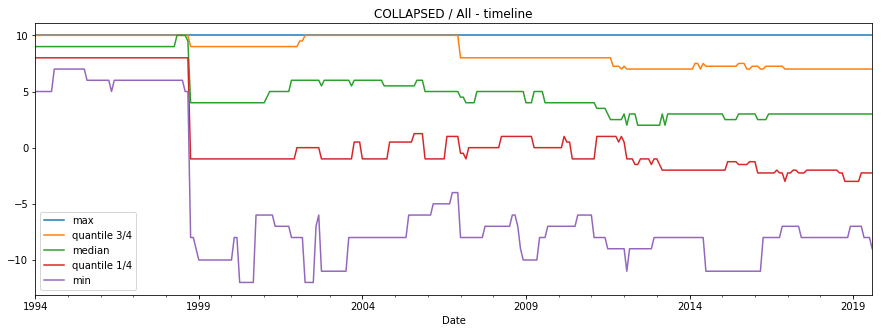

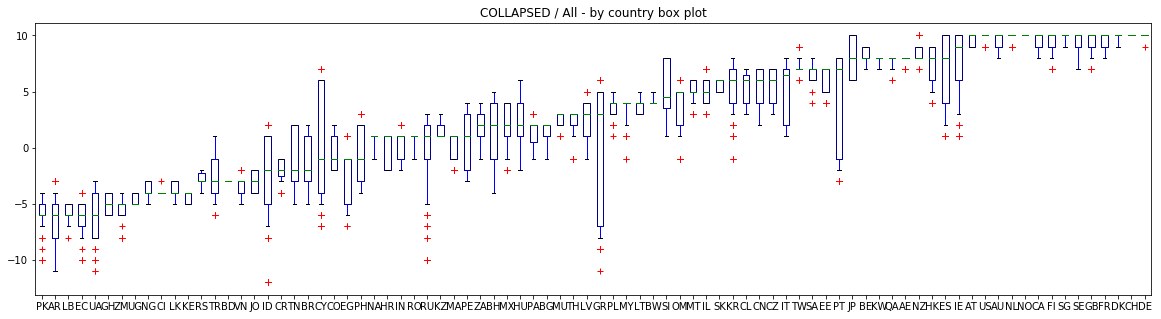

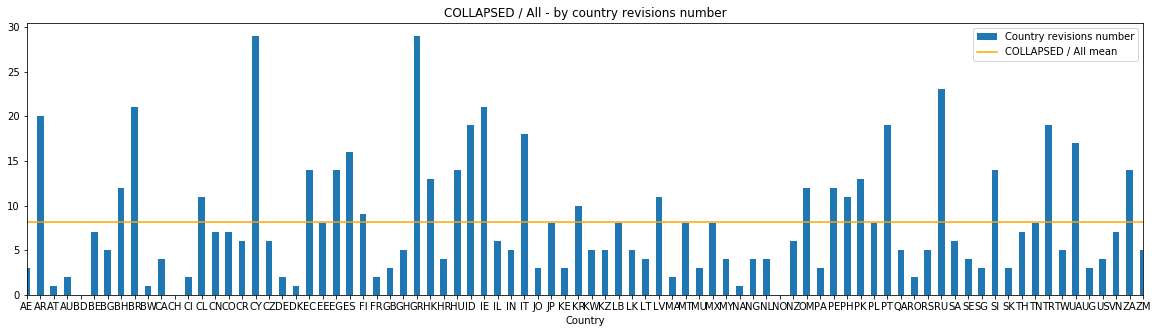

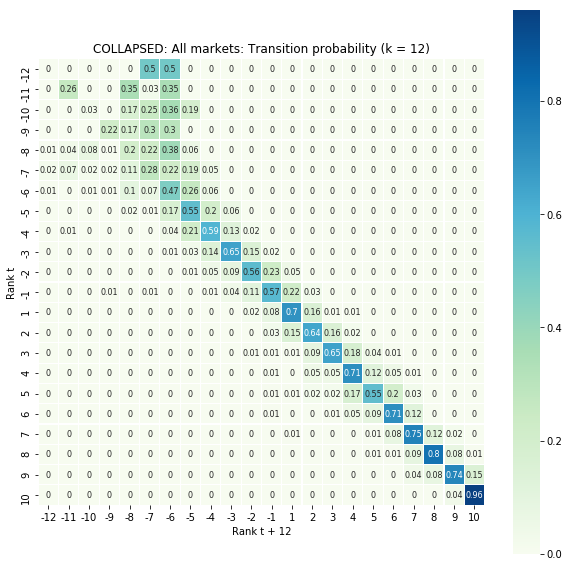

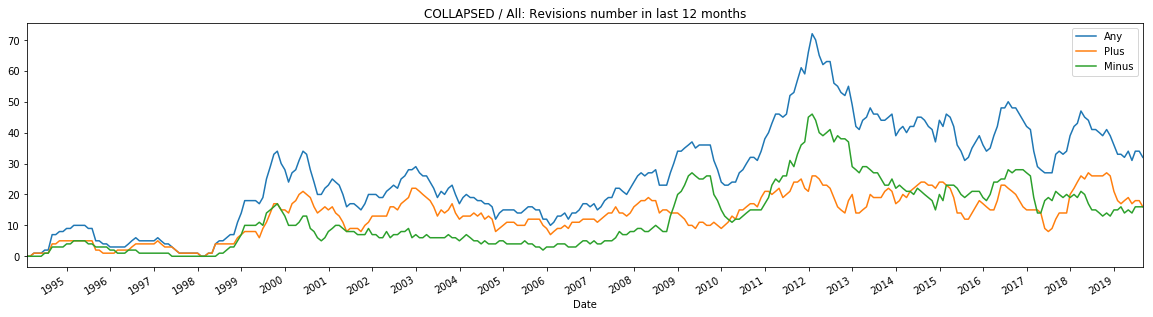

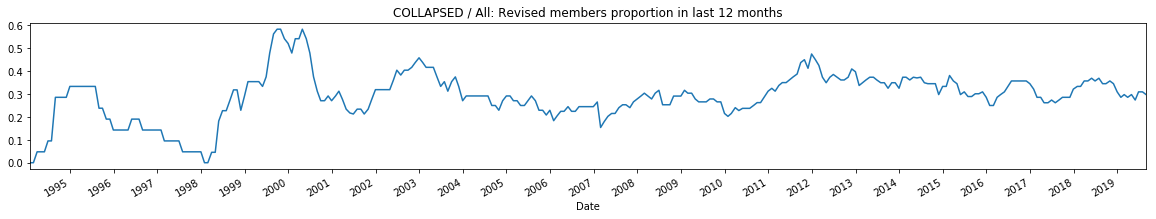

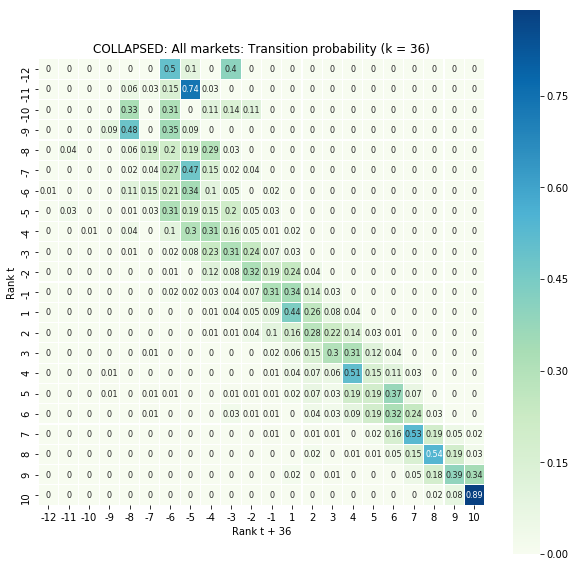

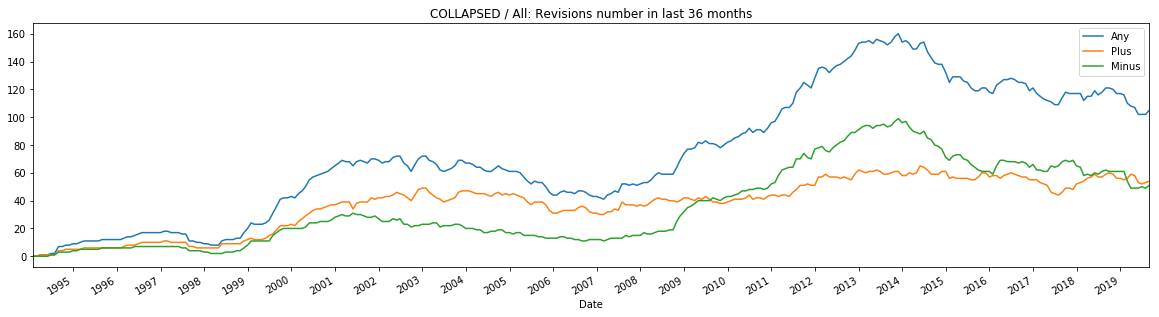

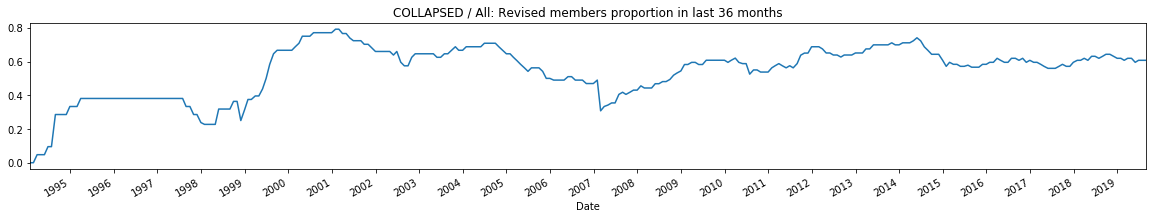

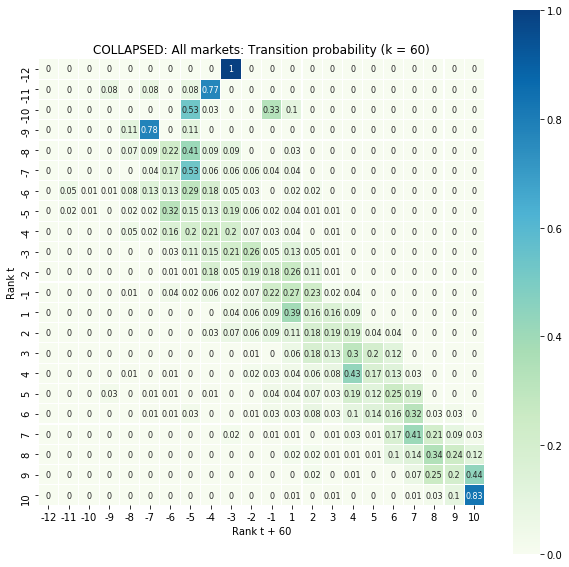

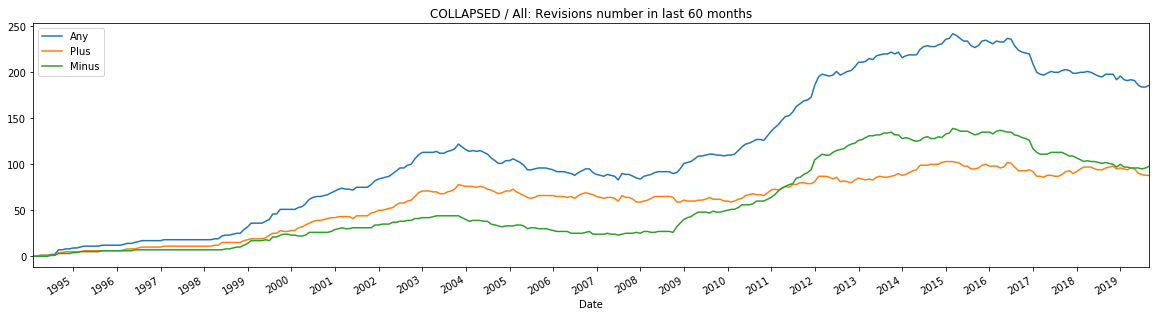

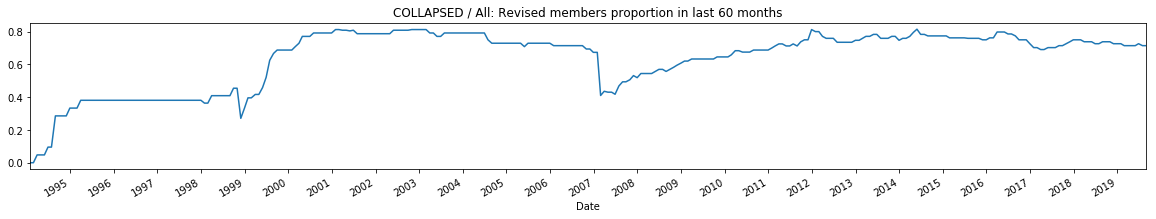

COLLAPSED : All markets ( 18400 ) : Countries covered: 84
COLLAPSED : All markets ( 18400 ) : Average observations per country: 219.05
COLLAPSED : All markets ( 18400 ) : Mean coverage per country: 98.59%
COLLAPSED : All markets ( 18400 ) : Investment grade: 73.76% ( 13572 )
COLLAPSED : All markets ( 18400 ) : Non-investment grade: 26.24% ( 4828 )
COLLAPSED : All markets ( 18400 ) : Any revisions frequency: 3.70% ( 681 )
COLLAPSED : All markets ( 18400 ) : Positive revisions frequency: 1.90% ( 349 )
COLLAPSED : All markets ( 18400 ) : Negative revisions frequency: 1.80% ( 332 )
COLLAPSED : All markets ( 18400 ) : Average revisions number for country: 8.11
COLLAPSED : All markets ( 18400 ) : Average stable rating period lentgh (months): 24.05
COLLAPSED : All markets: Mean revision absolute step: 1.28
COLLAPSED : All markets: Mean revision positive step: 1.26
COLLAPSED : All markets: Mean revision negative step: -1.3
COLLAPSED : All markets: Mean cross-sectional interquantile range (betw

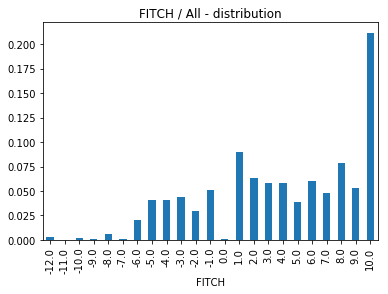

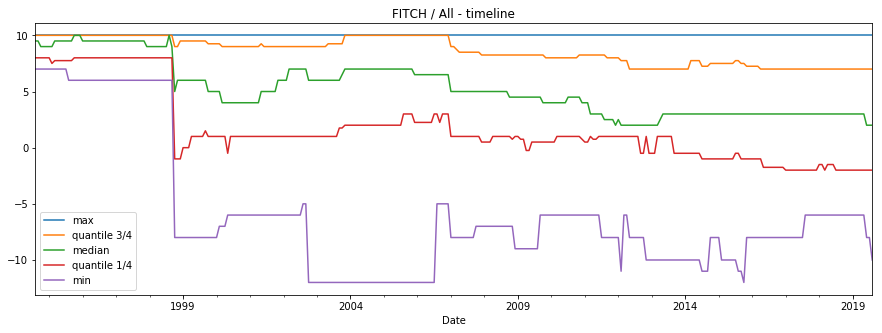

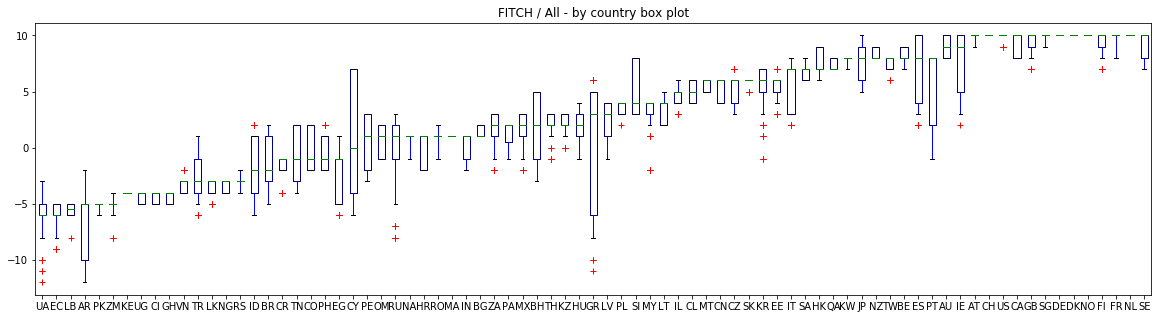

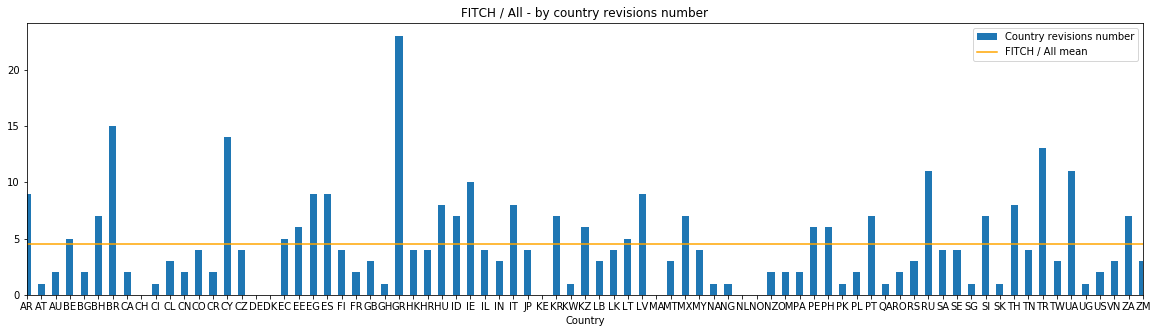

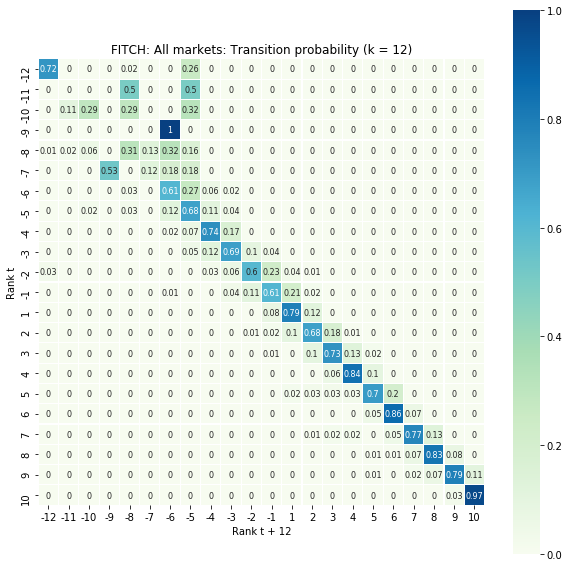

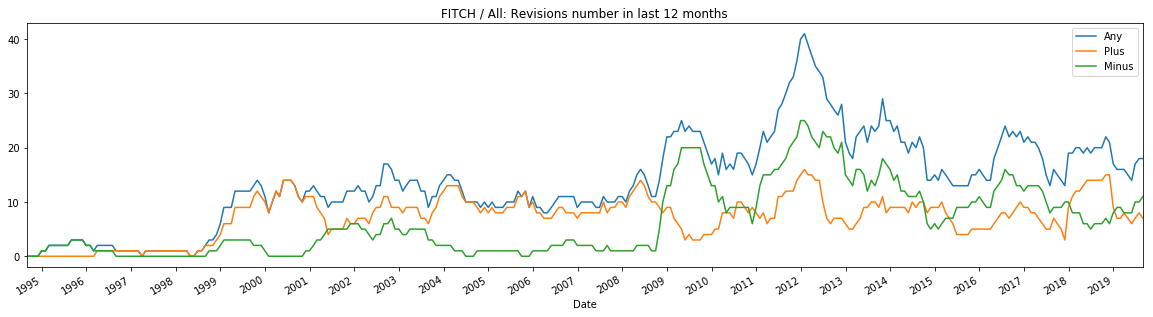

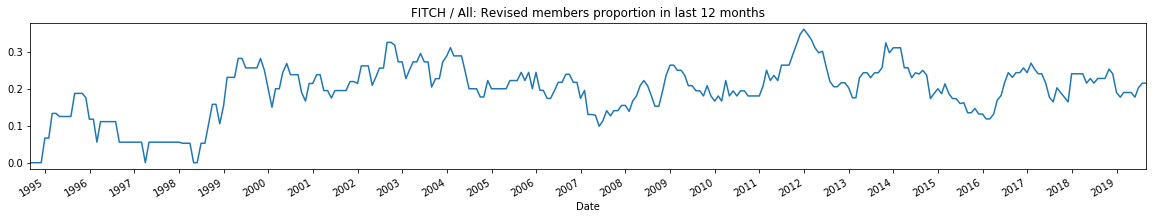

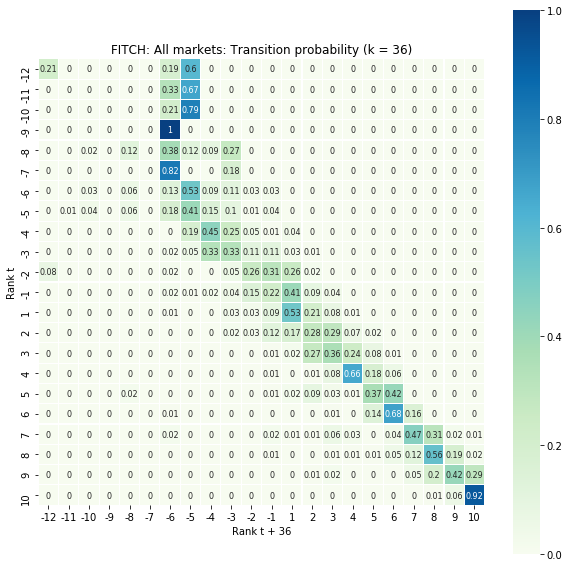

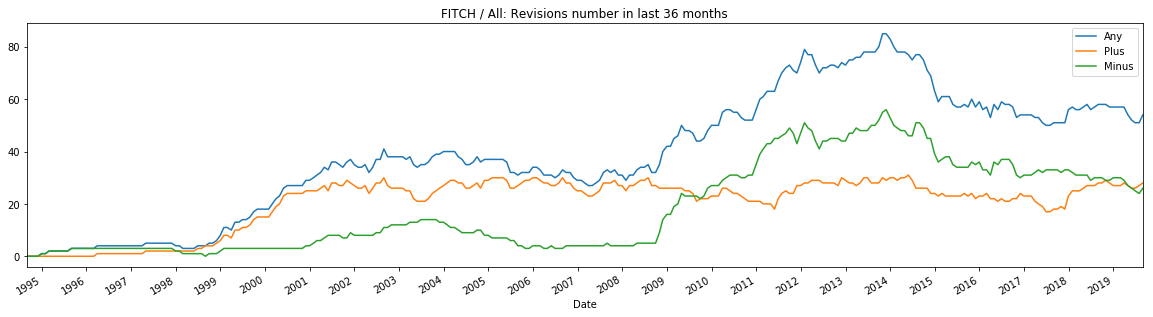

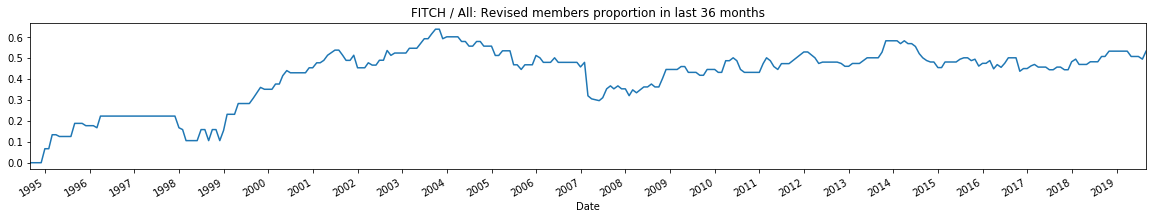

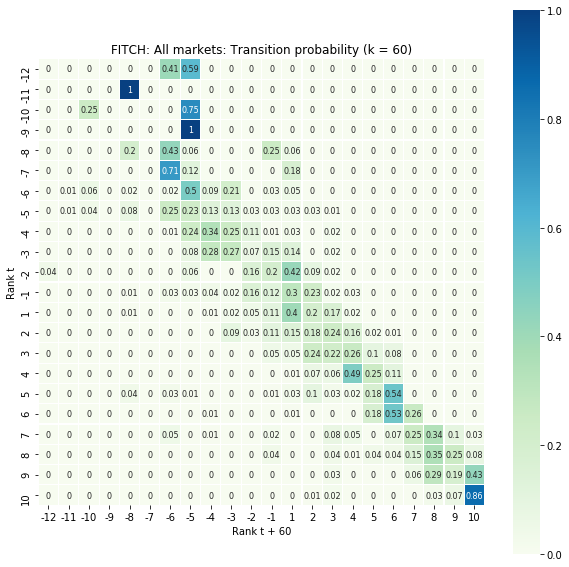

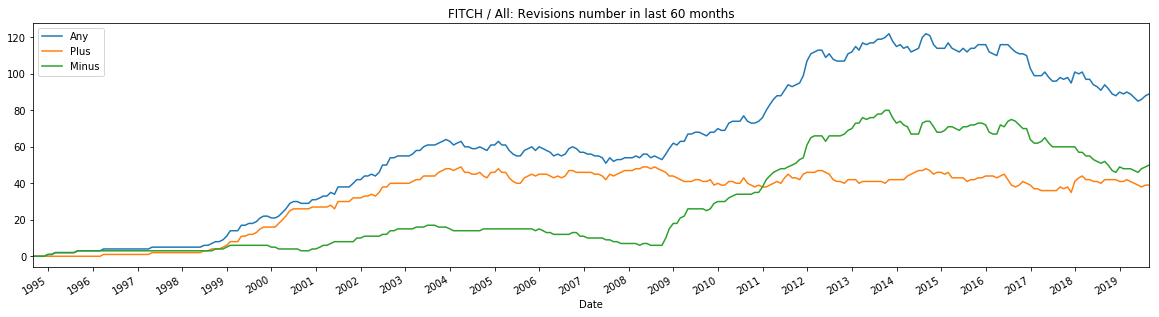

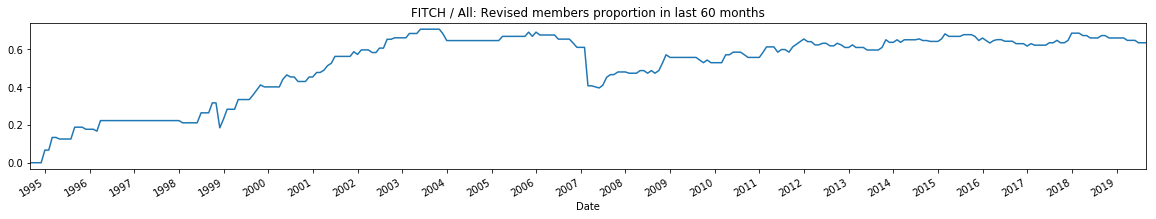

FITCH : All markets ( 16458 ) : Countries covered: 79
FITCH : All markets ( 16458 ) : Average observations per country: 208.33
FITCH : All markets ( 16458 ) : Mean coverage per country: 92.71%
FITCH : All markets ( 16458 ) : Investment grade: 76.02% ( 12512 )
FITCH : All markets ( 16458 ) : Non-investment grade: 23.89% ( 3931 )
FITCH : All markets ( 16458 ) : Any revisions frequency: 2.16% ( 355 )
FITCH : All markets ( 16458 ) : Positive revisions frequency: 1.13% ( 186 )
FITCH : All markets ( 16458 ) : Negative revisions frequency: 1.03% ( 169 )
FITCH : All markets ( 16458 ) : Average revisions number for country: 4.49
FITCH : All markets ( 16458 ) : Average stable rating period lentgh (months): 37.92
FITCH : All markets: Mean revision absolute step: 1.34
FITCH : All markets: Mean revision positive step: 1.26
FITCH : All markets: Mean revision negative step: -1.41
FITCH : All markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile): 11.76
FITCH : All markets: M

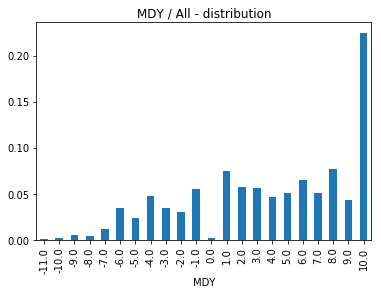

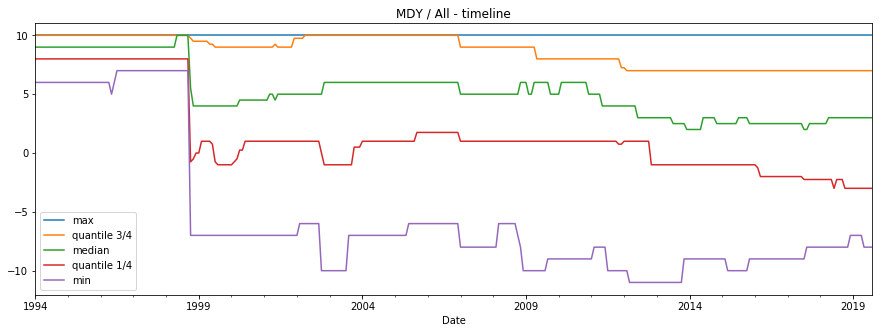

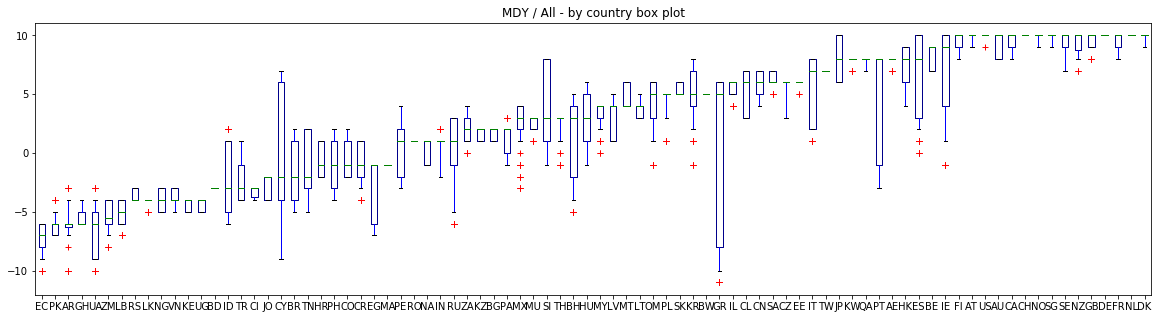

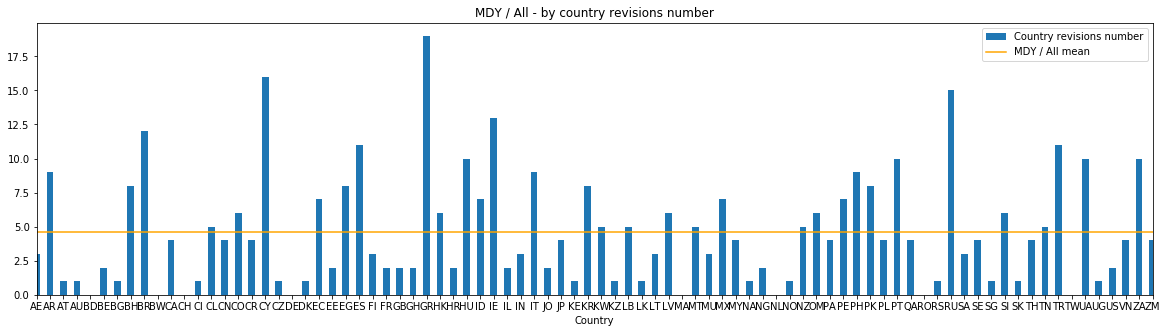

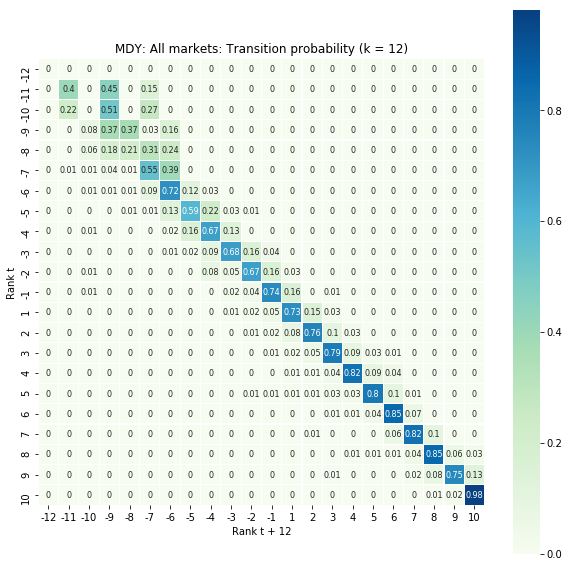

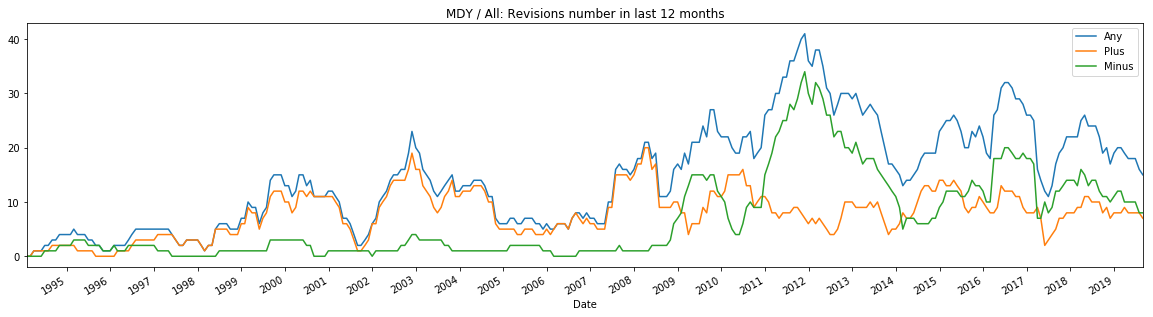

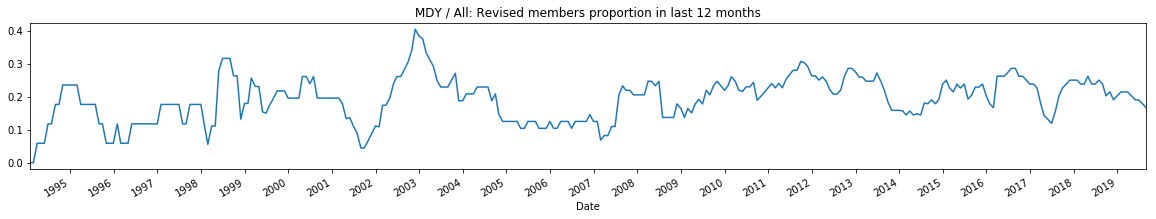

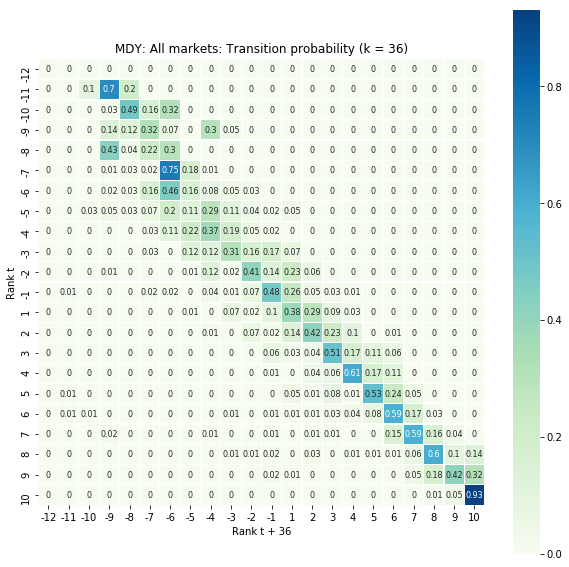

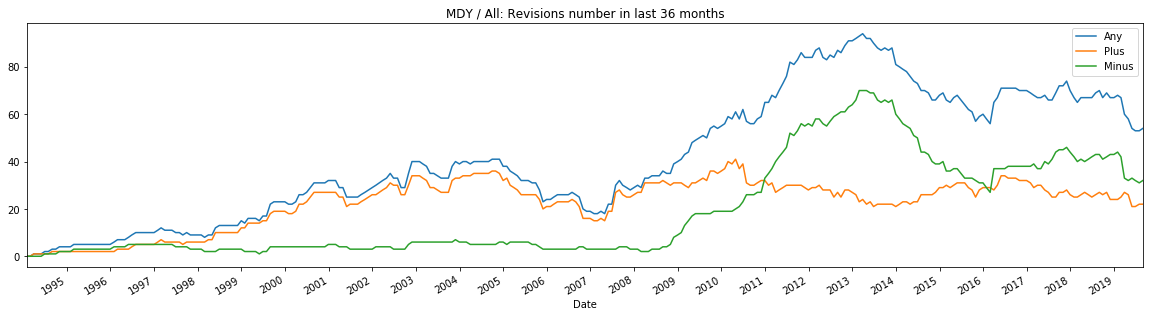

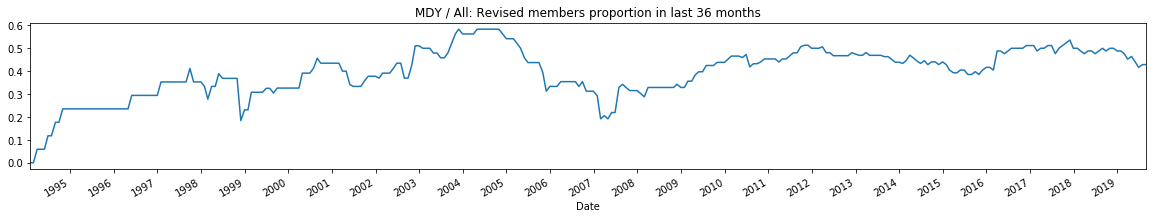

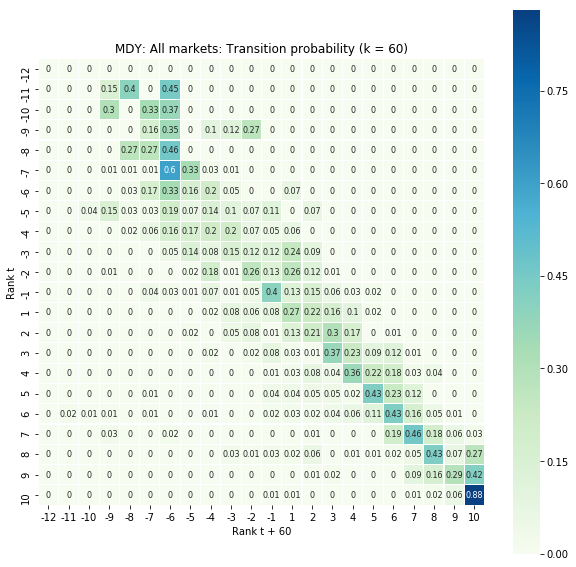

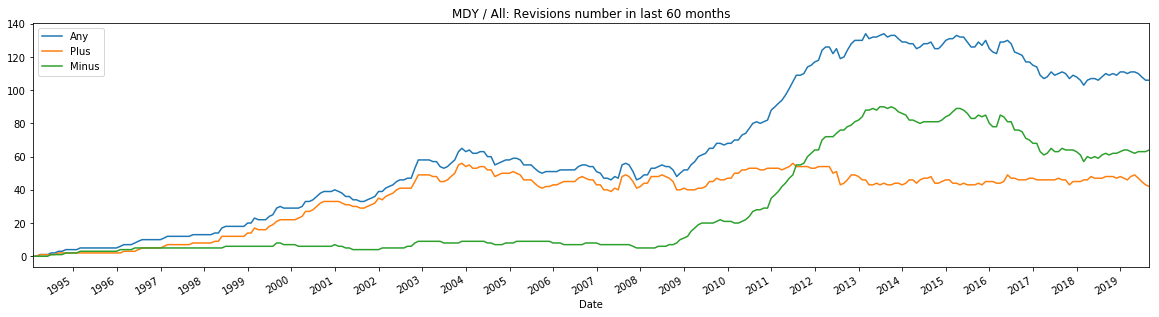

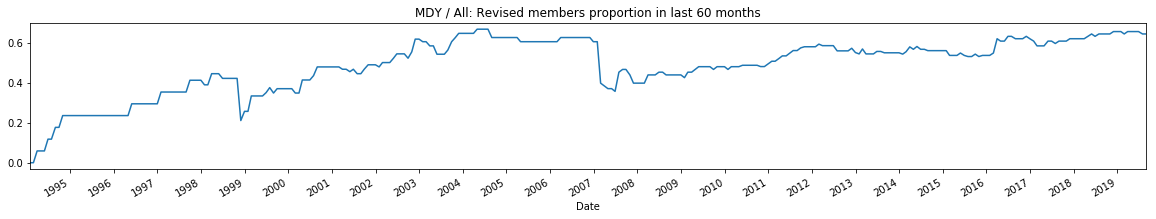

MDY : All markets ( 17596 ) : Countries covered: 84
MDY : All markets ( 17596 ) : Average observations per country: 209.48
MDY : All markets ( 17596 ) : Mean coverage per country: 93.70%
MDY : All markets ( 17596 ) : Investment grade: 74.74% ( 13152 )
MDY : All markets ( 17596 ) : Non-investment grade: 25.04% ( 4406 )
MDY : All markets ( 17596 ) : Any revisions frequency: 2.19% ( 385 )
MDY : All markets ( 17596 ) : Positive revisions frequency: 1.17% ( 205 )
MDY : All markets ( 17596 ) : Negative revisions frequency: 1.02% ( 180 )
MDY : All markets ( 17596 ) : Average revisions number for country: 4.58
MDY : All markets ( 17596 ) : Average stable rating period lentgh (months): 37.52
MDY : All markets: Mean revision absolute step: 1.28
MDY : All markets: Mean revision positive step: 1.18
MDY : All markets: Mean revision negative step: -1.39
MDY : All markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile): 11.67
MDY : All markets: Mean cross-sectional median: 5.

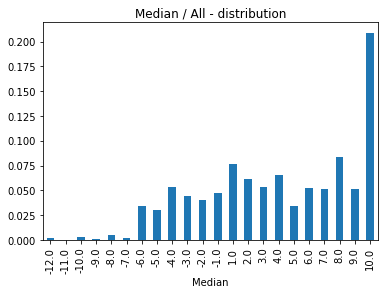

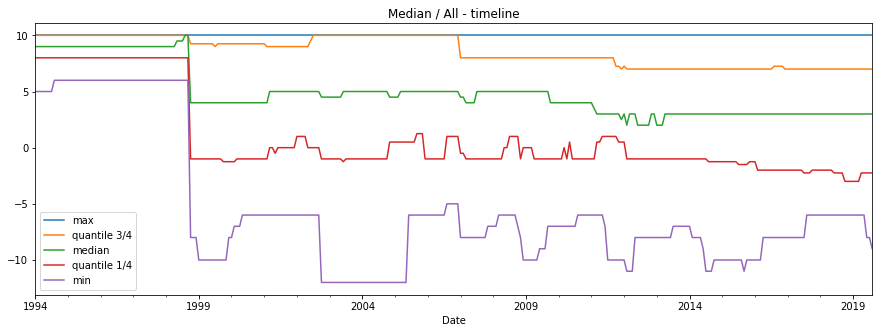

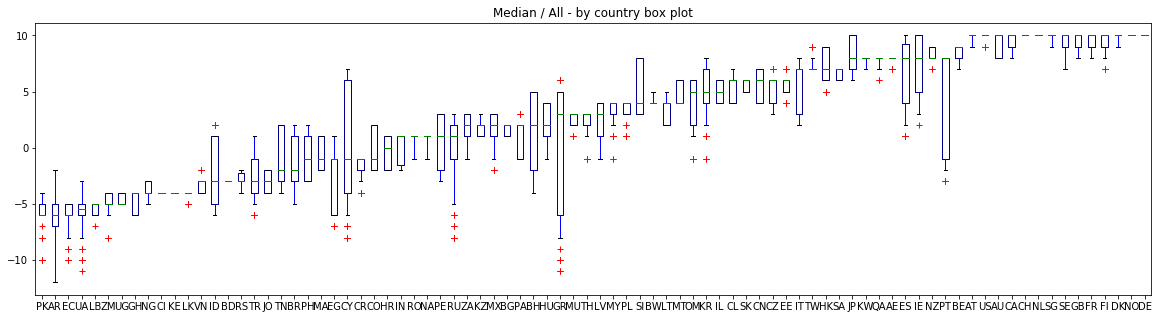

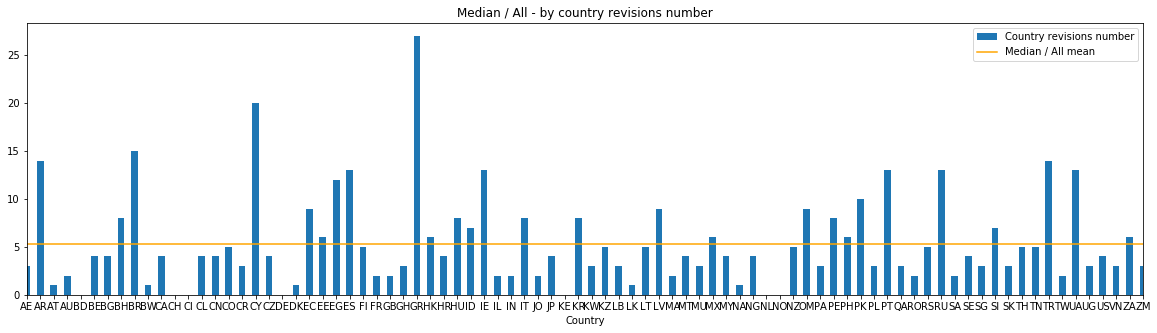

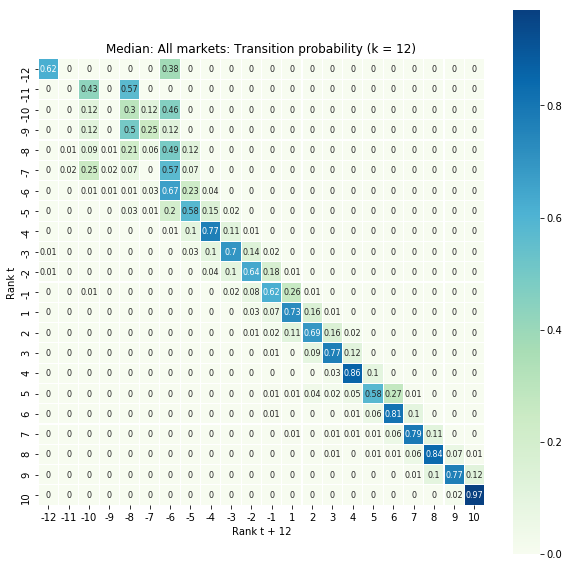

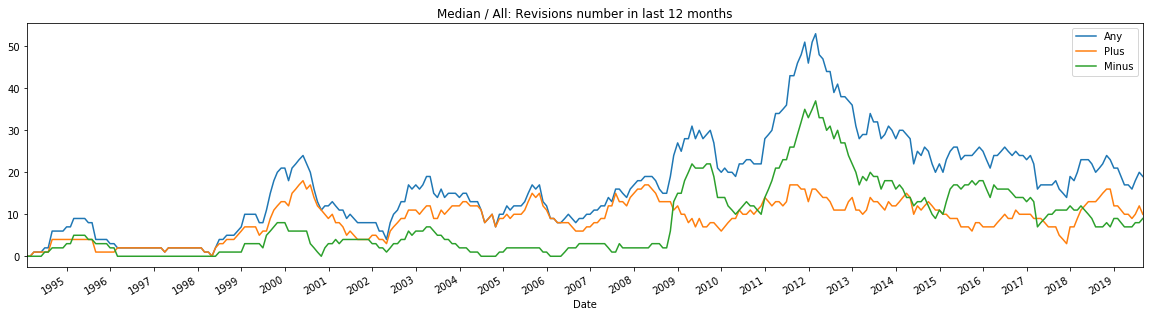

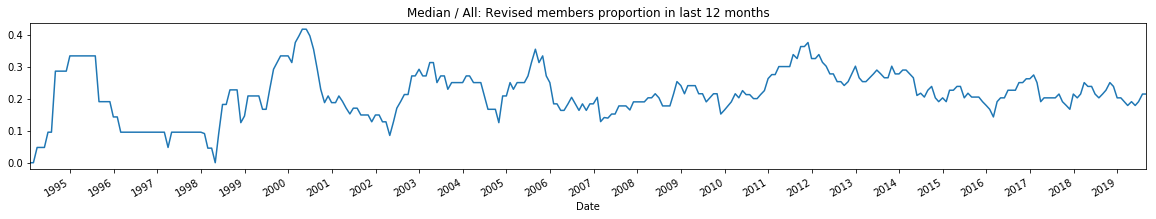

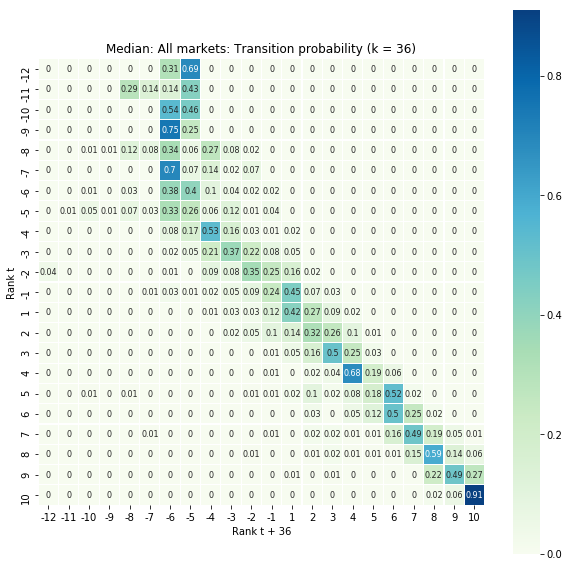

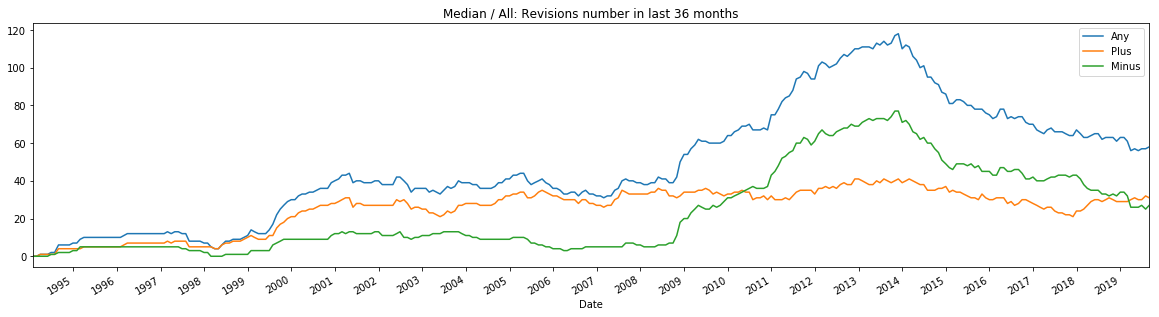

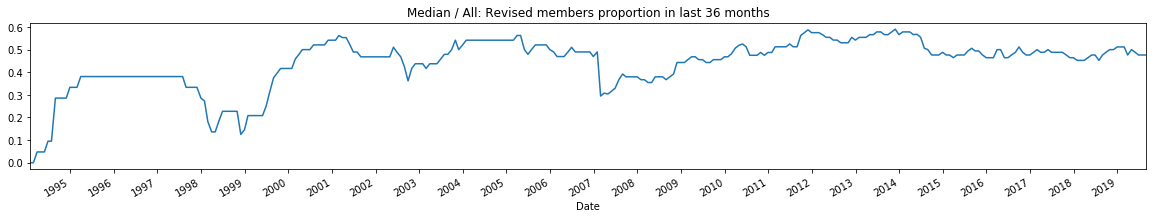

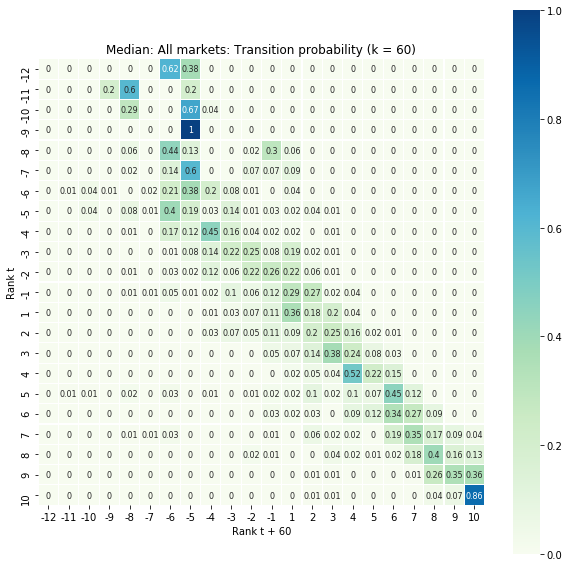

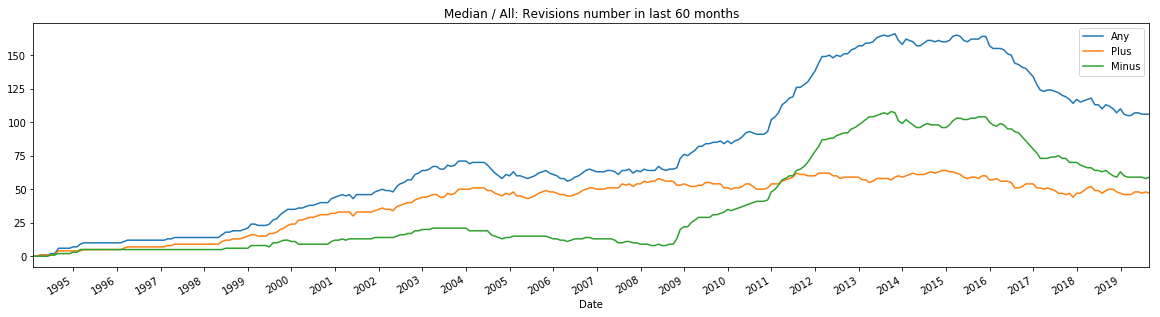

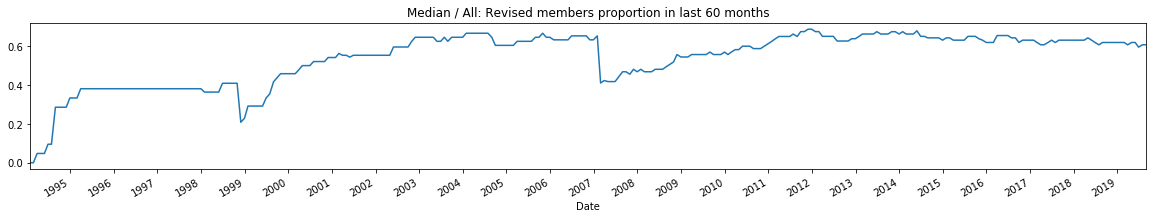

Median : All markets ( 18400 ) : Countries covered: 84
Median : All markets ( 18400 ) : Average observations per country: 219.05
Median : All markets ( 18400 ) : Mean coverage per country: 98.59%
Median : All markets ( 18400 ) : Investment grade: 73.78% ( 13576 )
Median : All markets ( 18400 ) : Non-investment grade: 26.22% ( 4824 )
Median : All markets ( 18400 ) : Any revisions frequency: 2.43% ( 447 )
Median : All markets ( 18400 ) : Positive revisions frequency: 1.26% ( 232 )
Median : All markets ( 18400 ) : Negative revisions frequency: 1.17% ( 215 )
Median : All markets ( 18400 ) : Average revisions number for country: 5.32
Median : All markets ( 18400 ) : Average stable rating period lentgh (months): 34.65
Median : All markets: Mean revision absolute step: 1.23
Median : All markets: Mean revision positive step: 1.19
Median : All markets: Mean revision negative step: -1.27
Median : All markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile): 11.79
Median :

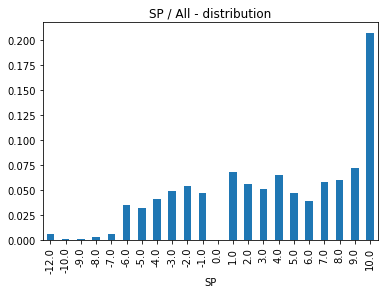

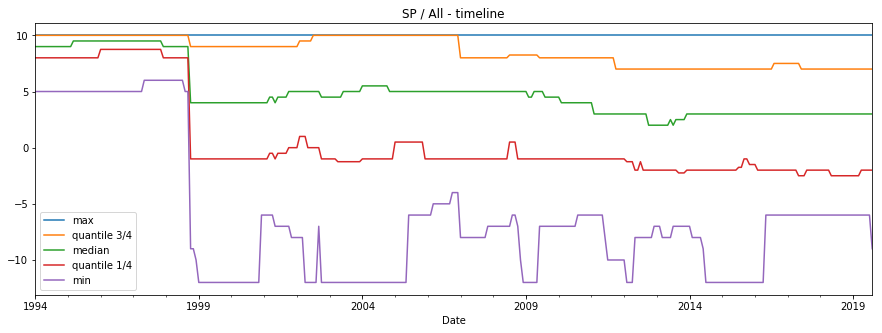

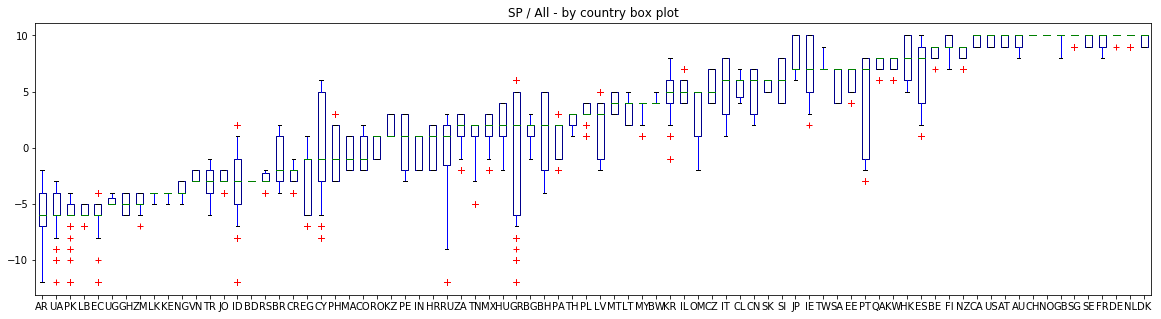

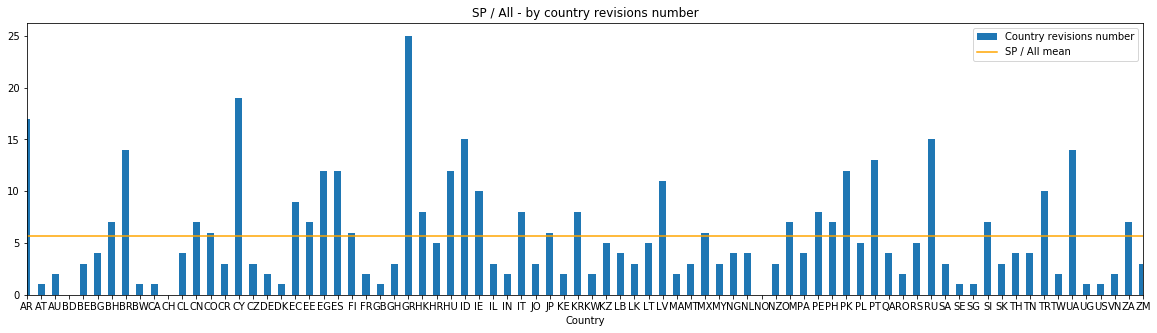

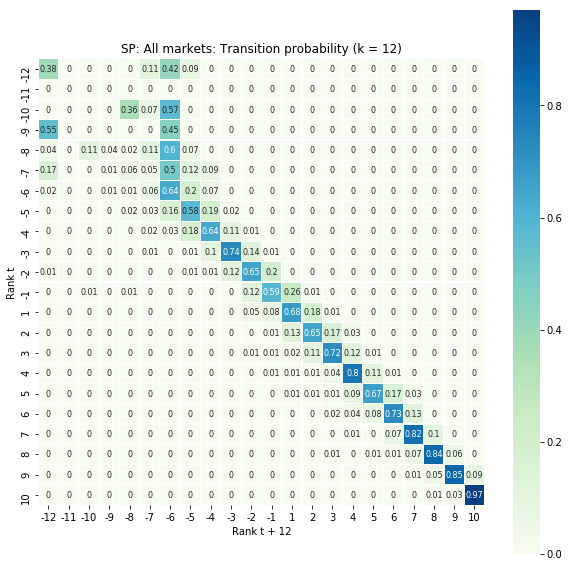

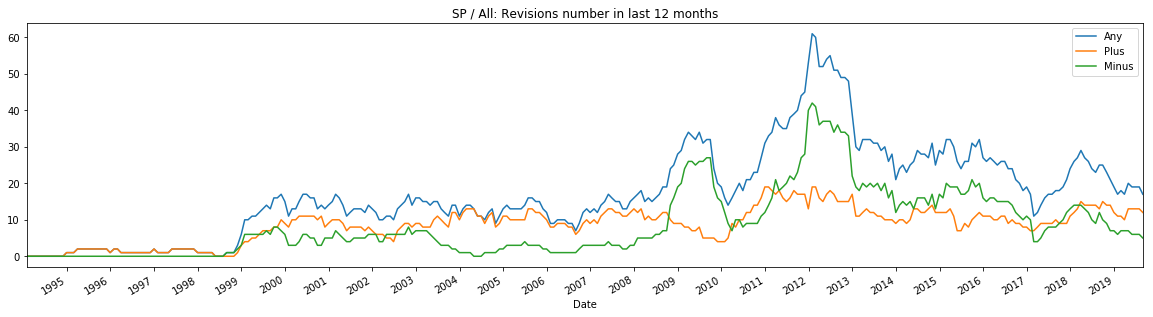

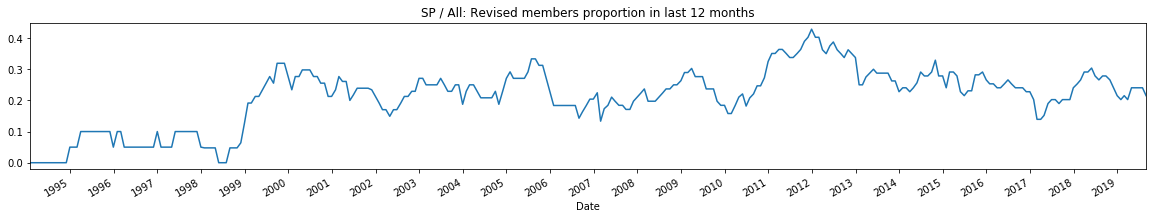

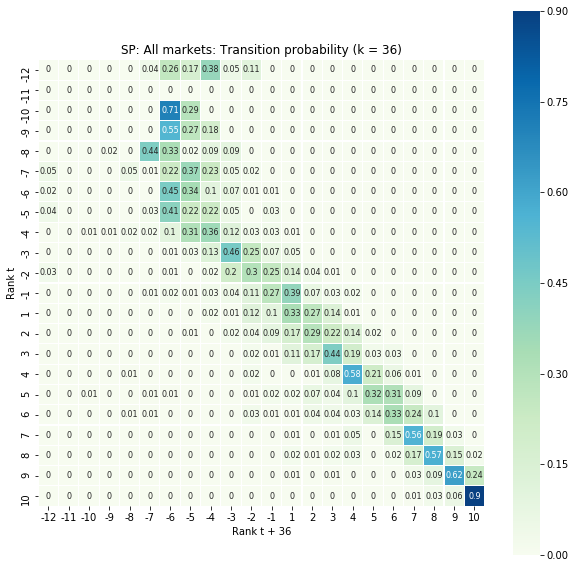

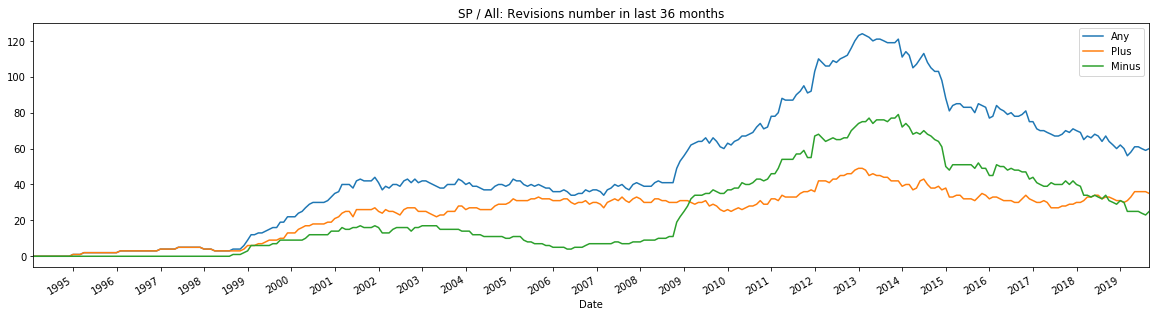

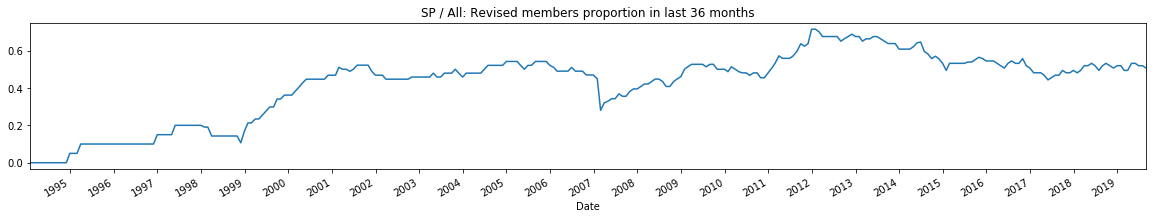

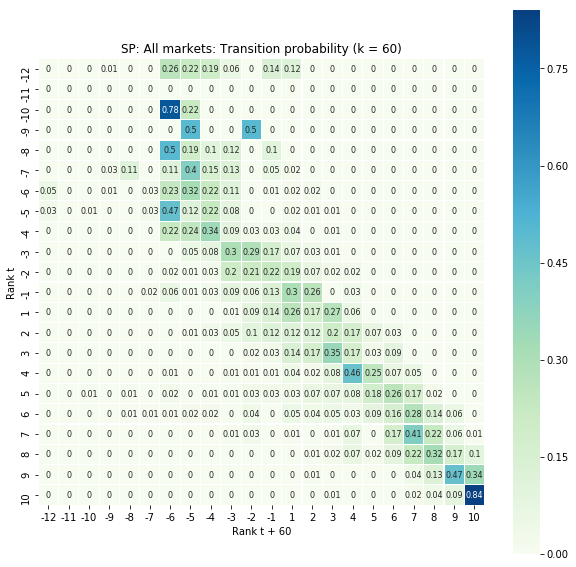

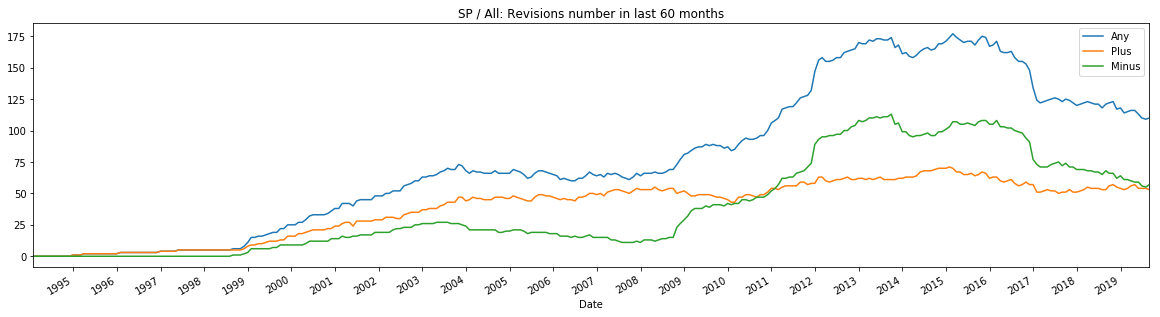

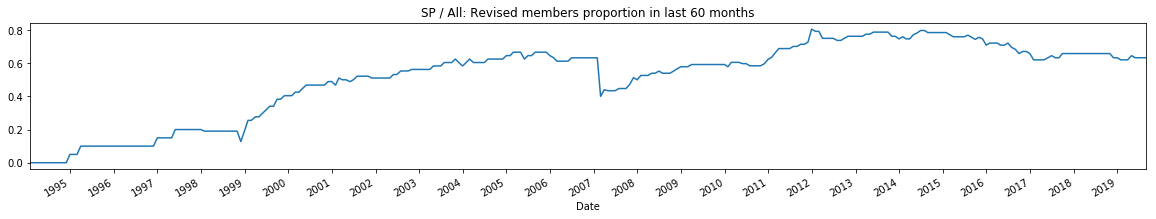

SP : All markets ( 17721 ) : Countries covered: 80
SP : All markets ( 17721 ) : Average observations per country: 221.51
SP : All markets ( 17721 ) : Mean coverage per country: 98.31%
SP : All markets ( 17721 ) : Investment grade: 72.48% ( 12845 )
SP : All markets ( 17721 ) : Non-investment grade: 27.48% ( 4870 )
SP : All markets ( 17721 ) : Any revisions frequency: 2.56% ( 454 )
SP : All markets ( 17721 ) : Positive revisions frequency: 1.29% ( 228 )
SP : All markets ( 17721 ) : Negative revisions frequency: 1.28% ( 226 )
SP : All markets ( 17721 ) : Average revisions number for country: 5.67
SP : All markets ( 17721 ) : Average stable rating period lentgh (months): 33.19
SP : All markets: Mean revision absolute step: 1.31
SP : All markets: Mean revision positive step: 1.3
SP : All markets: Mean revision negative step: -1.32
SP : All markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile): 11.7
SP : All markets: Mean cross-sectional median: 4.93
SP : All marke

In [11]:
### AGENCIES BEHAVIOR AND DISTRIBUTION ANALYZING
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
### Constants for universe filtering:
arr_tup_index = [(All, All, All), (All, 'DM', All), (All, 'EM', All), (All, 'FM', All)]
arr_tup_market = ['All', 'DM', 'EM', 'FM']
#arr_tup_index = [(All, All, All), (All, 'DM', All), (All, ['EM', 'FM'], All)]
#arr_tup_market = ['All', 'DM', 'EM & FM']
### Constants for crosstab plotting:
arr_ranks = np.arange(-12, 11, 1)
arr_ranks = arr_ranks[arr_ranks != 0]
### Constants for rolling calculations:
arr_roll_max = [12, 36, 60]
### Function for calculating length of constant rating periods:
def rolling_count(iter_delta):
    if (iter_delta == 0):
        rolling_count.iter_counter = rolling_count.iter_counter + 1
        rolling_count.iter_result = 0
    else:
        rolling_count.iter_result = rolling_count.iter_counter
        rolling_count.iter_counter = 1
    return rolling_count.iter_result
rolling_count.iter_counter = 1 
rolling_count.iter_result = 0
### Receiving MSCI membership data:    
ser_market_membership = get_market_membership_from_excel(path_msci)
### Preparing data for analysing:
df_rating_agg = df_rating_collapsed.copy()
#df_rating_agg.drop(['Median', 'Mean'], axis = 1, inplace = True)
#df_rating_agg.columns = ['FITCH', 'MDY', 'SP', 'COLLAPSED']
df_rating_agg.drop(['Mean'], axis = 1, inplace = True)
df_rating_agg.columns = ['FITCH', 'MDY', 'SP', 'Median', 'COLLAPSED']
df_rating_agg['COLLAPSED'] = round(df_rating_agg['COLLAPSED'], 0)
df_rating_agg['Median'] = round(df_rating_agg['Median'], 0)
df_rating_agg = df_rating_agg.reindex(sorted(df_rating_agg.columns), axis = 1)
### Main loop:
for iter_agency in df_rating_agg.columns: ### Agencies iterating
    for iter_num, iter_tup_market in enumerate(arr_tup_index):  ### Universe filters iterating
        ### Grades series defining:
        iter_ser_grades = df_rating_agg.loc[iter_tup_market, iter_agency].dropna().sort_index(level = ['Country', 'Date'], ascending = [True, True])
        ### Counter for country rankings:
        iter_ser_counter = iter_ser_grades.groupby('Country').count()
        ### Deltas series calculation:
        iter_ser_deltas = df_rating_agg.loc[All, iter_agency].dropna().groupby('Country').diff().sort_index(level = ['Country', 'Date'], ascending = [True, True])
        ### Rolling revisions number for every date calculation:
        arr_df_roll_flag_date = {}
        arr_df_roll_flag_market = {}    
        arr_df_crosstab = {}        
        for iter_roll_max in arr_roll_max:
            num_roll_max = iter_roll_max
            num_roll_min = 2 # num_roll_max // 2
            iter_ser_flag = iter_ser_deltas.copy()
            iter_ser_flag[iter_ser_flag != 0] = iter_ser_flag / iter_ser_flag.abs()
            iter_ser_flag_plus = iter_ser_flag.copy()
            iter_ser_flag_plus[iter_ser_flag_plus != 1] = 0
            iter_ser_flag_minus = iter_ser_flag.copy()
            iter_ser_flag_minus[iter_ser_flag_minus != -1] = 0
            iter_ser_roll_flag_plus = iter_ser_flag_plus.groupby('Country').rolling(window = num_roll_max, min_periods = num_roll_min).sum()
            iter_ser_roll_flag_plus = iter_ser_roll_flag_plus.reset_index(level = 0, drop = True)
            iter_ser_roll_flag_minus = iter_ser_flag_minus.abs().groupby('Country').rolling(window = num_roll_max, min_periods = num_roll_min).sum()
            iter_ser_roll_flag_minus = iter_ser_roll_flag_minus.reset_index(level = 0, drop = True)
            iter_ser_roll_flag = iter_ser_roll_flag_plus + iter_ser_roll_flag_minus
            iter_df_roll_flag = pd.concat([iter_ser_roll_flag, iter_ser_roll_flag_plus, iter_ser_roll_flag_minus], axis = 1)
            iter_df_roll_flag.sort_index(level = ['Country', 'Date'], ascending = [True, True], inplace = True)  
            iter_df_roll_flag = iter_df_roll_flag.loc[iter_tup_market, All]
            iter_df_roll_flag.columns = ['Any', 'Plus', 'Minus']
            iter_df_roll_flag_date = iter_df_roll_flag.groupby('Date').sum()          
            arr_df_roll_flag_date[num_roll_max] = iter_df_roll_flag_date
            iter_df_roll_flag_market_all = iter_df_roll_flag.groupby('Date')
            iter_df_roll_flag_market_revised = iter_df_roll_flag[iter_df_roll_flag['Any'] > 0].groupby('Date')
            iter_df_roll_flag_market = iter_df_roll_flag_market_revised.count().div(iter_df_roll_flag_market_all.count())['Any']
            iter_df_roll_flag_market.fillna(0, inplace = True)
            arr_df_roll_flag_market[num_roll_max] = iter_df_roll_flag_market            
            ### Transparency matrix preparing:
            iter_ser_crosstab = df_rating_agg.loc[All, iter_agency].dropna()
            num_crosstab_plus = iter_roll_max
            iter_ser_crosstab_step = iter_ser_crosstab.groupby('Country').shift(-num_crosstab_plus)
            df_crosstab = pd.concat([iter_ser_crosstab, iter_ser_crosstab_step], ignore_index = True, axis = 1)
            df_crosstab = df_crosstab.loc[iter_tup_market, All]    
            df_crosstab.sort_index(level = ['Country', 'Date'], ascending = [True, True], inplace = True)
            df_crosstab.columns = ['Rank t', 'Rank t + ' + str(num_crosstab_plus)]
            df_crosstab.dropna(inplace = True)
            df_crosstab = round(df_crosstab, 0)
            df_crosstab = df_crosstab.astype(int)
            df_crosstab = pd.crosstab(df_crosstab['Rank t'], df_crosstab['Rank t + ' + str(num_crosstab_plus)], normalize = 0, dropna = False)
            df_crosstab = df_crosstab.reindex(arr_ranks, axis = 0)
            df_crosstab = df_crosstab.reindex(arr_ranks, axis = 1)
            df_crosstab.fillna(0.00, inplace = True)
            df_crosstab = round(df_crosstab, 2)      
            arr_df_crosstab[num_crosstab_plus] = df_crosstab      
        ### Constant periods lengths series calculation:
        iter_ser_deltas = iter_ser_deltas.shift(-1)    
        iter_ser_distances = iter_ser_deltas.apply(rolling_count)
        iter_ser_distances = iter_ser_distances.loc[iter_tup_market]
        iter_ser_deltas = iter_ser_deltas.shift()  
        iter_ser_deltas = iter_ser_deltas.loc[iter_tup_market]
        ### Deltas number for countries calculation:        
        iter_ser_deltas_countries = iter_ser_deltas.dropna()[iter_ser_deltas != 0].groupby('Country').count()
        iter_ser_deltas_countries = iter_ser_deltas_countries / iter_ser_deltas.dropna().groupby('Country').count()
        iter_ser_deltas_countries.fillna(0, inplace = True)
        iter_ser_deltas_countries = iter_ser_deltas_countries * iter_ser_deltas.dropna().groupby('Country').count()
        
        iter_ser_deltas_countries.name = 'Country revisions number'
        ### Mean deltas for universe filter:
        iter_ser_deltas_mean = pd.Series(iter_ser_deltas_countries.mean(), index = iter_ser_deltas_countries.index)        
        iter_ser_deltas_mean.name = iter_agency + ' / ' + arr_tup_market[iter_num] + ' mean'
        ### Filtered universe grades distribution drawing:
        (iter_ser_grades.groupby(iter_ser_grades).count() / iter_ser_grades.count()).plot(kind = 'bar', 
                                                                                          title = iter_agency + ' / ' + arr_tup_market[iter_num] + ' - distribution')
        plt.show()        
        ### Timeline for filtered market time-series aggregating:
        grouper_market_by_country = iter_ser_grades.groupby('Country')
        ### Timeline for filtered market plotting:
        grouper_market_by_date = iter_ser_grades.groupby('Date')
        df_timeline_market = pd.concat([grouper_market_by_date.max(), grouper_market_by_date.quantile(0.75), grouper_market_by_date.median(), 
                                        grouper_market_by_date.quantile(0.25), grouper_market_by_date.min()], axis = 1)
        df_timeline_market.columns = ['max', 'quantile 3/4', 'median', 'quantile 1/4', 'min']
        df_timeline_market.plot(figsize = (15, 5), title = iter_agency + ' / ' + arr_tup_market[iter_num] + ' - timeline')
        plt.show()        
        ### Timeline for filtered countries plotting:
        dict_color = {'boxes': 'DarkBlue', 'medians': 'Green', 'whiskers': 'Blue', 'caps': 'Black'}
        iter_ser_grades.unstack('Country').reindex(iter_ser_grades.unstack('Country').median().sort_values().index, axis = 1).plot.box(figsize = (20, 5), 
                                                                                title = iter_agency + ' / ' + arr_tup_market[iter_num] + ' - by country box plot',
                                                                                color = dict_color, sym = 'r+', whis = [10, 90])
        plt.show()
        ### Revisions number for filtered countries plotting:        
        iter_ser_deltas_countries.plot.bar(figsize = (20, 5), title = iter_agency + ' / ' + arr_tup_market[iter_num] + ' - by country revisions number',
                                           legend = True, width = 0.5)
        iter_ser_deltas_mean.plot(color = 'Orange', legend = True)
        plt.show()
        for iter_roll_max in arr_roll_max:        
            ### Transition probability matrix plotting:
            num_crosstab_plus = iter_roll_max
            df_crosstab = arr_df_crosstab[num_crosstab_plus]
            plt.figure(figsize = (10, 10))
            plot_heatmap = sns.heatmap(df_crosstab, linewidths = 0.1, square = True, annot = True, annot_kws = {'size': 8},
                        cmap = 'GnBu')
            plot_heatmap.set_title(iter_agency + ': ' + arr_tup_market[iter_num] + ' markets: Transition probability (k = ' + str(num_crosstab_plus) + ')')
            plt.show()      
            ### Revisions number by date plotting:
            num_roll_max = iter_roll_max
            iter_df_roll_flag_date = arr_df_roll_flag_date[num_roll_max]
            plot_roll_flag_date = iter_df_roll_flag_date.plot(figsize = (20, 5), x_compat = True)
            plot_roll_flag_date.set_title(iter_agency + ' / ' +  arr_tup_market[iter_num] + ': Revisions number in last ' + str(num_roll_max) + ' months')
            plot_roll_flag_date.xaxis.set_major_locator(mdates.YearLocator())
            plt.gcf().autofmt_xdate()
            plt.show() 
            
            iter_df_roll_flag_market = arr_df_roll_flag_market[num_roll_max]
            plot_roll_flag_market = iter_df_roll_flag_market.plot(figsize = (20, 3), x_compat = True)
            plot_roll_flag_market.set_title(iter_agency + ' / ' +  arr_tup_market[iter_num] + ': Revised members proportion in last ' + str(num_roll_max) + ' months')
            plot_roll_flag_market.xaxis.set_major_locator(mdates.YearLocator())    
            plt.gcf().autofmt_xdate()
            plt.show()             
        ### Displaying statistics for filtered universe:
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Countries covered:', iter_ser_counter.count())   
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average observations per country:', round(iter_ser_counter.mean(), 2)) 
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Mean coverage per country:', '{:.2%}'.format((iter_ser_counter / (ser_market_membership.groupby('Country').size() - 1)).mean()))
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Investment grade:', '{:.2%}'.format(len(iter_ser_grades[iter_ser_grades > 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_grades[iter_ser_grades > 0].index), ')')
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Non-investment grade:', '{:.2%}'.format(len(iter_ser_grades[iter_ser_grades < 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_grades[iter_ser_grades < 0].index), ')')      
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Any revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas.dropna()[iter_ser_deltas != 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas.dropna()[iter_ser_deltas != 0].index), ')')
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Positive revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas[iter_ser_deltas > 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas[iter_ser_deltas > 0].index), ')')  
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Negative revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas[iter_ser_deltas < 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas[iter_ser_deltas < 0].index), ')')
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average revisions number for country:', round(iter_ser_deltas_countries.mean(), 2))        
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average stable rating period lentgh (months):', 
              round(iter_ser_distances[iter_ser_distances > 0].mean(), 2)) 
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean revision absolute step:', 
              round(iter_ser_deltas.abs()[iter_ser_deltas != 0].mean(), 2))   
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean revision positive step:', 
              round(iter_ser_deltas[iter_ser_deltas > 0].mean(), 2))
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean revision negative step:', 
              round(iter_ser_deltas[iter_ser_deltas < 0].mean(), 2))
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_date.quantile(0.90) - grouper_market_by_date.quantile(0.10)).mean(), 2))
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean cross-sectional median:', 
              round(grouper_market_by_date.median().mean(), 2))       
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean country interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_country.quantile(0.90) - grouper_market_by_country.quantile(0.10)).mean(), 2))
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Median country interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_country.quantile(0.90) - grouper_market_by_country.quantile(0.10)).median(), 2))       
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets:  Mean absolute deviation for countries mean:', 
              round(grouper_market_by_country.mad().mean(), 2))         
        print(iter_agency, ':', arr_tup_market[iter_num], 'markets:  Mean absolute deviation for countries median:', 
              round(grouper_market_by_country.mad().median(), 2))        
        for iter_roll_max in arr_roll_max:
            num_roll_max = iter_roll_max
            iter_df_roll_flag_date = arr_df_roll_flag_date[num_roll_max]
            iter_df_roll_flag_market = arr_df_roll_flag_market[num_roll_max]
            print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', len(iter_df_roll_flag_date.index), 'datepoints)',
                  ': Datepoints with at least one revision in last', num_roll_max,'months:', 
                  '{:.2%}'.format(len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] > 0].index) / len(iter_df_roll_flag_date.index)), 
                  '(', len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] > 0].index), ')')
            print(iter_agency, ':', arr_tup_market[iter_num], 'markets (', len(iter_df_roll_flag_date.index), 'datepoints)',
                  ': Datepoints with no revisions in last', num_roll_max,'months:', 
                  '{:.2%}'.format(len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] == 0].index) / len(iter_df_roll_flag_date.index)), 
                  '(', len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] == 0].index), ')')
            print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean any revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Any'].mean(), 2)) 
            print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean positive revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Plus'].mean(), 2)) 
            print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean negative revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Minus'].mean(), 2))   
            print(iter_agency, ':', arr_tup_market[iter_num], 'markets: Mean proportion of members revised in last', num_roll_max,'months from market:',
                  '{:.2%}'.format(round(iter_df_roll_flag_market.mean(), 4)))         

#        if (iter_num == 1):
#            break
        break        
#    if (iter_agency == 'FITCH'):
#        break
#    break

In [19]:
### SAVING COLLAPSE RANKING TO HDF FILE
ser_ranking = df_rating_agg['COLLAPSED']
ser_ranking.name = 'Rank'
path_collapsed = 'Data_Files/Source_Files/Collapsed_Rank_Not_Marked.h5'
path_collapsed_marked = 'Data_Files/Source_Files/Collapsed_Rank_Marked.h5'
key_collapsed = 'Rank'
#ser_ranking.to_hdf(path_collapsed, key_collapsed, mode = 'w', format = 'fixed')
#ser_ranking.to_hdf(path_collapsed_marked, key_collapsed, mode = 'w', format = 'fixed')
#ser_ranking.to_excel('Data_Files/Test_Files/Test_Collapsed_Rank_Marked.xlsx')

In [ ]:
### COUNTRY ISO CODES EXTRACTOR
def get_country_codes(use_local_copy = False):  
    import pandas as pd
    
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']]      
    df_result.index = df_result.index.str.upper()

    return df_result

In [ ]:
### INTERACTIVE RANKING WORLD MAP VISUALIZING
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon    
import bokeh.plotting as b_pl
import bokeh.models as b_md    
from bokeh.palettes import inferno, viridis, cividis, magma, plasma, all_palettes
from bokeh.layouts import widgetbox
from bokeh.layouts import column as b_col
from bokeh.layouts import row as b_row
from bokeh.models.widgets import DateSlider, Select
from bokeh.models import CustomJS

path_collapsed = 'Data_Files/Source_Files/Collapsed_Rank.h5'
key_collapsed = 'Rank'
ser_ranking = pd.read_hdf(path_collapsed, key_collapsed)

path_countries_map_shp = 'Data_Files/Source_Files/Geo_info/ne_110m_admin_0_countries.shp'

### Integrating long codes to ranking data table:
df_ranking = ser_ranking.to_frame()
df_ranking.index.set_names('ISO SHORT', level = 2, inplace = True)
df_country_codes = get_country_codes().set_index('ISO SHORT', drop = True)
df_ranking = df_ranking.join(df_country_codes, on = 'ISO SHORT', how = 'left')
### Creating data table for class evolution through month/year to further connect with Slider bokeh widget:
df_ranking.reset_index(inplace = True)
df_ranking.rename(columns={'ISO LONG': 'Country'}, inplace = True)
df_ranking['Year_Month'] = df_ranking['Date'].dt.to_period('M')
df_ranking = df_ranking[['Year_Month', 'Market', 'Country', 'Rank']]
df_ranking.set_index(['Year_Month'], inplace = True)
### Exporting geo data:
gdf_file_countries = gpd.read_file(path_countries_map_shp)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf_file_countries.columns = ['Country_Name', 'Country_Long_Code', 'Country_Geometry']
gdf_file_countries.sort_values('Country_Long_Code', inplace = True)
gdf_file_countries = gdf_file_countries[gdf_file_countries['Country_Name'] != 'Antarctica']
### Converting polygons to coordinates arrays dataframe for bokech patches:
arr_names = []
arr_codes = []
arr_arr_x = []
arr_arr_y = []
### Extacting polygons from gdf file:
for country_counter, (country_name, country_long_code, country_geometry) in gdf_file_countries.iterrows():
    ### For group of polygons:
    if isinstance(country_geometry,  MultiPolygon):
        for country_polygon in country_geometry:
            arr_names.append(country_name)            
            arr_codes.append(country_long_code)
            arr_arr_x.append(list(country_polygon.exterior.coords.xy[0]))
            arr_arr_y.append(list(country_polygon.exterior.coords.xy[1]))             
    ### For single polygons:            
    else:
        country_polygon = country_geometry
        arr_names.append(country_name)               
        arr_codes.append(country_long_code)
        arr_arr_x.append(list(country_polygon.exterior.coords.xy[0]))
        arr_arr_y.append(list(country_polygon.exterior.coords.xy[1]))  
### Constructing dataframe with row for each polygon:            
tup_country_coords = tuple(zip(arr_names, arr_codes, arr_arr_x, arr_arr_y))
df_country_coords = pd.DataFrame(list(tup_country_coords), columns = ['Country_Name', 'Country_Long_Code', 'Coord_X_Array', 'Coord_Y_Array'])
df_country_coords.set_index(['Country_Long_Code', 'Country_Name'], inplace = True)

### Configuring latest known MSCI data as initial world map classification data source:
df_last_date = df_ranking.loc[df_ranking.index.values.max()]
df_last_date = df_last_date.reset_index()
df_last_date.set_index('Country', inplace = True)
df_last_date.drop('Year_Month', axis = 1 ,inplace = True)
df_country_show = df_country_coords.merge(df_last_date, how = 'left', left_on = 'Country_Long_Code', right_index = True)
### Class select additional data connectors constructing:
dict_classes_select = {'Developed Markets': 'DM', 'Emerging Markets': 'EM', 'Frontier Markets': 'FM', 'All Markets': 'ALL'}
dict_classes_mirror = dict(zip(dict_classes_select.values(), dict_classes_select.keys()))
arr_classes_select = list(dict_classes_select.keys())
arr_classes_index = list(dict_classes_select.values())
### Creating transit dataframe as container for data transfer betwwen widgets and figures:
df_meta_transit = pd.DataFrame([str(df_ranking.index.values.max()), 'ALL'], index = ['Year_Month', 'Market']).T
### Preparing by date market status dictionary to dyhnamic changing cds sources
dict_market = {}
dict_ranking = {}
for iter_year_month in df_ranking.sort_index(level = 'Year_Month').index.get_level_values('Year_Month').unique():
    iter_ser_year_month = df_ranking.loc[iter_year_month, ['Market', 'Country']].reset_index(drop = True).set_index('Country').squeeze()
    dict_market[str(iter_year_month)] = iter_ser_year_month.reindex(df_country_show.index.get_level_values(0)).values
    dict_ranking[str(iter_year_month)] = {}
    for iter_market in arr_classes_index:       
        iter_arr_include = [iter_market]
        if (iter_market == 'ALL'):
            iter_arr_include = arr_classes_index[ : -1]
        iter_ser_market = df_ranking.loc[iter_year_month].reset_index(drop = True).set_index('Country')
        iter_ser_market = iter_ser_market.loc[iter_ser_market['Market'].isin(iter_arr_include)]
        dict_ranking[str(iter_year_month)][iter_market] = iter_ser_market.reindex(df_country_show.index.get_level_values(0))['Rank'].values
### Defining output to notebook or to html file:
b_pl.output_notebook()
#b_pl.output_file('Ranking_evolution.html')
### Bokeh Data Source defining:
src_meta_transit =  b_pl.ColumnDataSource(df_meta_transit) ### For data transfer betwwen elements
src_country_show =  b_pl.ColumnDataSource(df_country_show.reset_index()) ### For world map borders
### Initialising worldmap classes evolution figure:
str_fig_worldmap_toolbar =  'pan, wheel_zoom, reset'
tup_fig_worldmap_size = (800, 400)
str_fig_worldmap_title = 'Universe debt ranking evolution'
fig_world_map = b_pl.figure(tools = str_fig_worldmap_toolbar, active_scroll = 'wheel_zoom', 
                            plot_width = tup_fig_worldmap_size[0], plot_height = tup_fig_worldmap_size[1],
                            title = str_fig_worldmap_title)
### Tuning worldmap figure:
fig_world_map.axis.visible = False
fig_world_map.xgrid.visible = False
fig_world_map.ygrid.visible = False
fig_world_map.toolbar.autohide = True
### Creating hover inspection to worldmap figure:    
fig_world_map.add_tools(b_md.HoverTool(tooltips = [('Country', '@Country_Name'), ('Market Class', '@Market'), ('Ranking', '@Rank{0,0}')], 
                                       formatters = {'Rank': 'numeral'}))
### Colors categorising and mapping:
palette_red_green = all_palettes['Plasma'][256][-79 : -10][::3] + all_palettes['Viridis'][256][-69 : ][::-1][::3]
linear_cm_rank = b_md.LinearColorMapper(low = -12, high = 10, palette = palette_red_green, nan_color = 'silver')
#inferno(23), viridis(23), cividis(23), magma(23), plasma(23)
#all_palettes['Viridis'][256][-23:][::-1]
### Drawing world map:
patches_world_map = fig_world_map.patches('Coord_X_Array', 'Coord_Y_Array', source = src_country_show,
                                          color = {'field': 'Rank', 'transform': linear_cm_rank}, fill_alpha = 1.0, line_color = 'lightgray', 
                                          line_width = 1.0)
### Adding rank value color bar to rank world map figure:
color_bar_class = b_md.ColorBar(color_mapper = linear_cm_rank, label_standoff = 8, width = 20, height = tup_fig_worldmap_size[1] - 100,
                                border_line_color = None, orientation = 'vertical', location = (0, 50),
                                ticker = b_md.AdaptiveTicker(desired_num_ticks = 23),
                                formatter = b_md.NumeralTickFormatter(format = '0.'))
fig_world_map.add_layout(color_bar_class, 'right')

### Drawing and tuning date slider widget, creating a trigger for it's changes:
callback_date_slider = CustomJS(args = dict(fig_map_to_update = fig_world_map, title_map_main_part = str_fig_worldmap_title, 
                                            cds_world = src_country_show, cds_transit = src_meta_transit,
                                            arr_classes_mirror = dict_classes_mirror,
                                            arr_dict_market = dict_market, arr_dict_ranking = dict_ranking),
                                code = """                             
                                       var market_selected = cds_transit.data['Market'];                                
                                       var date_chosen = new Date(cb_obj.value);
                                       var arr_months = ['January', 'February', 'March', 'April', 'May', 'June', 
                                                         'July', 'August', 'September', 'October', 'November', 'December'];
                                       var date_month_name = arr_months[date_chosen.getMonth()];

                                       fig_map_to_update.title.text = title_map_main_part + ': ' + arr_classes_mirror[market_selected] + ' | ';
                                       fig_map_to_update.title.text = fig_map_to_update.title.text  + date_chosen.getFullYear() + ' / ' + date_month_name;
                                       var date_year_month = date_chosen.getFullYear().toString();
                                       if (date_chosen.getMonth() > 8)
                                       {
                                           date_year_month = date_year_month + '-' + (date_chosen.getMonth() + 1).toString();
                                       }
                                        else
                                       {
                                           date_year_month = date_year_month + '-' + '0' + (date_chosen.getMonth() + 1).toString();
                                       }                                                                         
                                       cds_world.data['Market'] = arr_dict_market[date_year_month];
                                       cds_world.data['Rank'] = arr_dict_ranking[date_year_month][market_selected];
                                       cds_world.change.emit();                               

                                       fig_map_to_update.change.emit(); 

                                       cds_transit.data['Year_Month'] = date_year_month;
                                       cds_transit.change.emit();                                        
                                       """)
date_min = ser_ranking.index.get_level_values(level = 0).min()
date_max = ser_ranking.index.get_level_values(level = 0).max()
slider_dates = DateSlider(title = 'Date to show ranking status', width = tup_fig_worldmap_size[0] - 50, 
                          start = date_min, end = date_max, step = 1, value = date_max)
slider_dates.callback_policy = 'throttle'
slider_dates.js_on_change('value', callback_date_slider)
slider_dates.tooltips = False

### Creating select widget for choosing class tuning (including connection between selected value and range slider boundaries):
callback_class_select = CustomJS(args = dict(fig_map_to_update = fig_world_map, title_map_main_part = str_fig_worldmap_title, 
                                             cds_world = src_country_show, cds_transit = src_meta_transit,
                                            arr_classes_select = dict_classes_select, arr_dict_ranking = dict_ranking),
                                 code = """
                                        var date_year_month = cds_transit.data['Year_Month'].toString();
                                        var date_year = date_year_month.substring(0, 4);
                                        var date_month = Number(date_year_month.substring(5)) - 1;
                                        var market_selected = arr_classes_select[cb_obj.value];  
                                        var arr_months = ['January', 'February', 'March', 'April', 'May', 'June', 
                                                          'July', 'August', 'September', 'October', 'November', 'December'];
                                        var date_month_name = arr_months[date_month];
                                        fig_map_to_update.title.text = title_map_main_part + ': ' + market_selected + ' | ';
                                        fig_map_to_update.title.text = title_map_main_part + ': ' + cb_obj.value + ' | ';
                                        fig_map_to_update.title.text = fig_map_to_update.title.text  + date_year + ' / ' + date_month_name;
                                        cds_world.data['Rank'] = arr_dict_ranking[date_year_month][market_selected];                                      
                                        cds_world.change.emit();                               
                                        fig_map_to_update.change.emit();
                                        
                                        cds_transit.data['Market'] = market_selected;
                                        cds_transit.change.emit(); 
                                        """)
select_class = Select(title = 'Select market class to show:', options = arr_classes_select, value = arr_classes_select[-1], callback = callback_class_select)

### Constructing common layout: 
layout_world = b_col(widgetbox(select_class), fig_world_map, widgetbox(slider_dates))
b_pl.show(layout_world)

In [ ]:
### EXPO WEIGHTED ILLUSTRATING
import matplotlib.pyplot as plt
num_window = 310
num_halflife = 3
ser_weights_halflife = get_exp_weights(window_len = num_window, halflife_len = num_halflife).reset_index(drop = True)
ser_weights_halflife.index = ser_weights_halflife.index - 300
#ser_weights_halflife.to_excel('Data_Files/Test_Files/Expo_Weights_360_3.xlsx', merge_cells = False)  
ser_weights_halflife.plot(figsize = (15, 2), title = 'Expo weights with 310 month array length and 3 month half-life period plot')
plt.show()

In [15]:
### COLLAPSED / PROVIDERS REVISIONS CORRELATION EXCLUDING COLLAPSED REVISION INITIATOR
import numpy as np
import pandas as pd
All = slice(None)
### Ranking vector reading:
df_rating_collapsed = pd.read_excel('Data_Files/Test_Files/Test_Collapsing_Full.xlsx')
#df_rating_collapsed = pd.read_excel('Data_Files/Test_Files/Test_Collapsing_Full_Marked_Plus.xlsx')
df_rating_collapsed = df_rating_collapsed.set_index(['Date', 'Market', 'Country'])
df_rating_collapsed.sort_index(level = ['Country', 'Date'])
df_rating_agg = df_rating_collapsed.copy()
df_rating_agg['COLLAPSED'] = round(df_rating_agg['Fresh month half life'], 0)
df_rating_agg.drop(['Fresh month half life', 'Mean'], axis = 1, inplace = True)
### Delta vector preparing:
num_delta_step = 1
df_rating_delta = df_rating_agg.groupby('Country').diff(num_delta_step).sort_index(level = ['Country', 'Date'], ascending = [True, True])
### Droppping constant collapsed ranking countries:
df_rating_delta = df_rating_delta.loc[df_rating_delta['COLLAPSED'].groupby('Country').filter(lambda iter_group: iter_group.abs().sum() != 0).index]
### Main loop for providers:
for iter_agency in df_rating_delta.columns.to_list():
    if (iter_agency != 'COLLAPSED'):
        ### Shifting leg:
        for num_shifter in (np.arange(5) + 1):
            ### Selecting columns for correlation:
            df_iter_agency_delta = df_rating_delta[['COLLAPSED', iter_agency]]
            ### Adding shifted providers delta ranking:
            df_iter_agency_delta = df_iter_agency_delta.assign(**{iter_agency + ' shifted': df_iter_agency_delta[iter_agency].shift(-num_shifter).values})  
            ### Dropping zero delta COLLAPSED values:            
            df_iter_agency_delta = df_iter_agency_delta.loc[df_iter_agency_delta['COLLAPSED'] != 0]                
            ### Dropping non-zero non-shifted delta provider values (excluding observations where COLLAPSED ranking changed by provider's ranking):
            df_iter_agency_delta = df_iter_agency_delta.loc[df_iter_agency_delta[iter_agency] == 0]
            ### Calculating correlation:
            df_iter_agency_corr = df_iter_agency_delta.corr()       
            df_iter_agency_corr.index.set_names(['Agency'], inplace = True)  
            ### Printing correlation result:
            print('Provider:', iter_agency, ', shift:', num_shifter, ':', round(df_iter_agency_corr.loc['COLLAPSED', iter_agency + ' shifted'], 2))
#    break

Provider: FITCH , shift: 1 : 0.31
Provider: FITCH , shift: 2 : 0.19
Provider: FITCH , shift: 3 : 0.26
Provider: FITCH , shift: 4 : 0.06
Provider: FITCH , shift: 5 : 0.1
Provider: MDY , shift: 1 : 0.2
Provider: MDY , shift: 2 : 0.19
Provider: MDY , shift: 3 : 0.23
Provider: MDY , shift: 4 : 0.04
Provider: MDY , shift: 5 : 0.14
Provider: SP , shift: 1 : 0.34
Provider: SP , shift: 2 : 0.11
Provider: SP , shift: 3 : 0.13
Provider: SP , shift: 4 : 0.15
Provider: SP , shift: 5 : 0.12
Provider: Median , shift: 1 : 0.29
Provider: Median , shift: 2 : 0.19
Provider: Median , shift: 3 : 0.21
Provider: Median , shift: 4 : 0.12
Provider: Median , shift: 5 : 0.13


In [18]:
### MARKS IMPACT ANALYSIS
path_collapsed = 'Data_Files/Source_Files/Collapsed_Rank_Not_Marked.h5'
path_collapsed_marked = 'Data_Files/Source_Files/Collapsed_Rank_Marked.h5'
key_collapsed = 'Rank'
ser_ranking_no_impact = pd.read_hdf(path_collapsed, key_collapsed)
ser_ranking_with_impact = pd.read_hdf(path_collapsed_marked, key_collapsed)

In [30]:
### TESTER
ser_diff_no_impact = ser_ranking_no_impact.dropna().groupby('Country').diff().abs()
print(ser_diff_no_impact[ser_diff_no_impact > 0].count())
print(ser_diff_no_impact[ser_diff_no_impact > 0].mean())
ser_diff_with_impact = ser_ranking_with_impact.dropna().groupby('Country').diff().abs()
print(ser_diff_with_impact[ser_diff_with_impact > 0].count())
print(ser_diff_with_impact[ser_diff_with_impact > 0].mean())


873
1.309278350515464
953
1.285414480587618
